In [1]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

import sklearn
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

import seaborn as sb
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from sklearn.feature_selection import SelectKBest, chi2

In [3]:
# download dataset from GDrive
downloaded1 = drive.CreateFile({'id':'1mUsEVVku7OnUF775YUVltO6dTAQb4off'}) # dfTrain_Raw
downloaded2 = drive.CreateFile({'id':'1nOd2cbfakVNwYqNHzd4F66JF9iabGcgf'}) # dfTest_Raw

downloaded3 = drive.CreateFile({'id':'1dAU4qQ9oIZ5lC7SdJsqPUf2N2o1sgzU9'}) # dfTrain_RawStem
downloaded4 = drive.CreateFile({'id':'1eBbjulZdjYfW_jCLGfxTEw85XP7yvOxQ'}) # dfTest_RawStem

downloaded5 = drive.CreateFile({'id':'1G0h6J7biKYNxjax8IVb03s9NT9fmt6x7'}) # dfTrain_Pre
downloaded6 = drive.CreateFile({'id':'1dxyEpiyatPBu4IfZSLdtGghUnBW2nAop'}) # dfTest_Pre

downloaded7 = drive.CreateFile({'id':'13xJkURph0xkMNZdR5oC3m-zIEdhruo5A'}) # dfTrain_PreStem
downloaded8 = drive.CreateFile({'id':'1YWvESQxqgRmKZHufxzUv81uJ-CPobY-U'}) # dfTest_PreStem

downloaded1.GetContentFile('dataset1.csv')
downloaded2.GetContentFile('dataset2.csv')
downloaded3.GetContentFile('dataset3.csv')
downloaded4.GetContentFile('dataset4.csv')
downloaded5.GetContentFile('dataset5.csv')
downloaded6.GetContentFile('dataset6.csv')
downloaded7.GetContentFile('dataset7.csv')
downloaded8.GetContentFile('dataset8.csv')

# Read file as panda dataframe
dfTrain_Raw = pd.read_csv('dataset1.csv')
dfTest_Raw = pd.read_csv('dataset2.csv')

dfTrain_RawStem = pd.read_csv('dataset3.csv')
dfTest_RawStem = pd.read_csv('dataset4.csv')

dfTrain_Pre = pd.read_csv('dataset5.csv')
dfTest_Pre = pd.read_csv('dataset6.csv')

dfTrain_PreStem = pd.read_csv('dataset7.csv')
dfTest_PreStem = pd.read_csv('dataset8.csv')

# dfRaw

In [4]:
dfTrain_Raw

,tweet,label
0,Peneliti: Presiden perlu bentuk Badan Otorita ...,0
1,Pembangunan PLTN di Kalbar mantapkan pemindaha...,1
2,Prabowo setuju karena pemindahan ibu kota suda...,1
3,Pemindahan ibu kota bukti Jokowi ingin adanya ...,1
4,Lah itu kan sdh mau di ringankan dg pemindahan...,1
...,...,...
1871,"Cocok dah pemindahan ibu ota, biar aja buaya k...",1
1872,Apakah pemindahan ibu kota negara ke Kalimanta...,0
1873,Amien Rais: Pemindahan ibu kota mempercepat pe...,-1
1874,Pemindahan ibu kota berhubungan dengan CINA Ke...,0


In [5]:
# defining predictor and target features
X_train = dfTrain_Raw['tweet']
y_train = dfTrain_Raw['label']

X_test = dfTest_Raw['tweet']
y_test = dfTest_Raw['label']

In [6]:
#encoding the corpus using Term Frequency - Inverse Document Frequency Encoding
Tfidf_vect = TfidfVectorizer()

In [7]:
#fitting encoder on training data
Tfidf_vect.fit(X_train)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [8]:
#Transforming the corpus for the training and testing data
Train_X_Tfidf = Tfidf_vect.transform(X_train)
Test_X_Tfidf = Tfidf_vect.transform(X_test)

In [9]:
#preview vocabulary vector
print(Tfidf_vect.vocabulary_)

{'peneliti': 4254, 'presiden': 4577, 'perlu': 4377, 'bentuk': 626, 'badan': 462, 'otorita': 4024, 'pemindahan': 4220, 'ibu': 2045, 'kota': 2840, 'antara': 349, 'news': 3830, 'berita': 707, 'terkini': 5613, 'pembangunan': 4181, 'pltn': 4507, 'di': 1195, 'kalbar': 2393, 'mantapkan': 3134, 'negara': 3819, 'prabowo': 4564, 'setuju': 5193, 'karena': 2437, 'sudah': 5372, 'menjadi': 3506, 'usulan': 5917, 'rencana': 4761, 'jangka': 2251, 'panjang': 4080, 'gerindra': 1807, 'sejak': 5041, '2014': 47, 'bukti': 939, 'jokowi': 2330, 'ingin': 2140, 'adanya': 189, 'pemerataan': 4203, 'lah': 2911, 'itu': 2198, 'kan': 2421, 'sdh': 4978, 'mau': 3186, 'ringankan': 4805, 'dg': 1189, 'sudahlah': 5374, 'pemerintah': 4206, 'lebih': 2962, 'paham': 4046, 'biaya': 818, 'ri': 4792, 'dari': 1113, 'pada': 4038, 'anda': 322, 'ngurusin': 3878, 'oke': 3977, 'oce': 3966, 'nga': 3831, 'becus': 580, 'tidak': 5690, 'usa': 5904, 'bicara': 820, 'kalau': 2392, 'tudak': 5791, 'tau': 5499, 'masalah': 3159, 'rakyatnya': 4694, 

In [10]:
#preview transformed training data
print(Train_X_Tfidf)

  (0, 5613)	0.3563452565974606
  (0, 4577)	0.19387409945709885
  (0, 4377)	0.2648459128125598
  (0, 4254)	0.3722192616389949
  (0, 4220)	0.05609791592511034
  (0, 4024)	0.38227958026455927
  (0, 3830)	0.28922579605456483
  (0, 2840)	0.05544419923685206
  (0, 2045)	0.0554737462180007
  (0, 707)	0.2765057343287494
  (0, 626)	0.3180980980416277
  (0, 462)	0.3387733026338769
  (0, 349)	0.3086155751245975
  (1, 5613)	0.3603488049028828
  (1, 4507)	0.3990256712883793
  (1, 4220)	0.0567281774820739
  (1, 4181)	0.24981105582204538
  (1, 3830)	0.2924752554601286
  (1, 3819)	0.1613695454458309
  (1, 3134)	0.4150780211929577
  (1, 2840)	0.05606711626967493
  (1, 2393)	0.3990256712883793
  (1, 2045)	0.05609699521193184
  (1, 1195)	0.14262293107175356
  (1, 707)	0.2796122835071545
  :	:
  (1874, 4091)	0.12581147783969432
  (1874, 2840)	0.03378630695724776
  (1874, 2638)	0.22682109945194
  (1874, 2045)	0.03380431214784459
  (1874, 1195)	0.08594524649984453
  (1874, 1155)	0.2268082399561473
  (1874, 

In [11]:
Train_X_Tfidf

<1876x6126 sparse matrix of type '<class 'numpy.float64'>'
	with 34298 stored elements in Compressed Sparse Row format>

In [12]:
TfidfVectorizer()

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [13]:
# Classifier - Algorithm - SVM
# fit the training dataset on the classifier
SVM = svm.SVC(kernel = 'linear')
SVM.fit(Train_X_Tfidf, y_train)

# Use accuracy_score function to get the accuracy
print("SVM Training Accuracy Score -> ", SVM.score(Train_X_Tfidf, y_train)*100)
print("SVM Testing Accuracy Score -> ", SVM.score(Test_X_Tfidf, y_test)*100)

SVM Training Accuracy Score ->  95.41577825159915
SVM Testing Accuracy Score ->  70.27363184079603


Model Optimazion

In [14]:
#initializing tfidf vectorizer and an SVM classifier instance
tfidf = TfidfVectorizer()
clf = svm.SVC()

In [15]:
#constructing the pipeline
pipe = Pipeline([
    ('tfidf', tfidf),
    ('clf', clf)
])

In [16]:
linear_grid = {'tfidf__max_features': [500, 1000, 5000, None],
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'clf__C': np.logspace(-1, 3, 5),
    'clf__kernel' : ['linear']}
    
poly_grid = {'tfidf__max_features': [500, 1000, 5000, None],
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'clf__C': np.logspace(-1, 3, 5),
    'clf__kernel' : ['poly'],
    'clf__degree' : [2, 3],
    'clf__gamma': np.logspace(-2, 2, 5)}

rbf_grid = {'tfidf__max_features': [500, 1000, 5000, None],
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'clf__C': np.logspace(-1, 3, 5),
    'clf__kernel' : ['rbf'],
    'clf__gamma': np.logspace(-2, 2, 5)}

In [17]:
scv_linear = RandomizedSearchCV(pipe, param_distributions = linear_grid, n_iter = 10, cv = 5, verbose = 2, n_jobs = -1, return_train_score = True, random_state = 42)
scv_linear.fit(X_train, y_train);

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   30.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   39.9s finished


In [18]:
#using a randomized grid search to find the optimal value of the hyperparameters over a 5-fold cross-validation
scv_poly = RandomizedSearchCV(pipe, param_distributions = poly_grid, n_iter = 10, cv = 5, verbose = 2, n_jobs = -1, return_train_score = True, random_state = 42)
scv_poly.fit(X_train, y_train);

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   39.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   50.4s finished


In [19]:
#using a randomized grid search to find the optimal value of the hyperparameters over a 5-fold cross-validation
scv_rbf = RandomizedSearchCV(pipe, param_distributions = rbf_grid, n_iter = 10, cv = 5, verbose = 2, n_jobs = -1, return_train_score = True, random_state = 42)
scv_rbf.fit(X_train, y_train);

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   43.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   57.9s finished


In [20]:
#preview randomized gridsearch results
pd.DataFrame(scv_linear.cv_results_)[['params', 'mean_train_score', 'mean_test_score']]

,params,mean_train_score,mean_test_score
0,"{'tfidf__ngram_range': (1, 1), 'tfidf__max_fea...",0.628333,0.534655
1,"{'tfidf__ngram_range': (1, 3), 'tfidf__max_fea...",0.623269,0.520800
2,"{'tfidf__ngram_range': (1, 1), 'tfidf__max_fea...",0.973347,0.516009
3,"{'tfidf__ngram_range': (1, 1), 'tfidf__max_fea...",0.997868,0.604499
4,"{'tfidf__ngram_range': (1, 2), 'tfidf__max_fea...",0.789047,0.594905
5,"{'tfidf__ngram_range': (1, 1), 'tfidf__max_fea...",0.997868,0.601299
6,"{'tfidf__ngram_range': (1, 1), 'tfidf__max_fea...",0.995869,0.608221
7,"{'tfidf__ngram_range': (1, 1), 'tfidf__max_fea...",0.986140,0.499471
8,"{'tfidf__ngram_range': (1, 1), 'tfidf__max_fea...",0.805438,0.583176
9,"{'tfidf__ngram_range': (1, 1), 'tfidf__max_fea...",0.997868,0.604499


In [21]:
pd.DataFrame(scv_poly.cv_results_)[['params', 'mean_train_score', 'mean_test_score']]

,params,mean_train_score,mean_test_score
0,"{'tfidf__ngram_range': (1, 3), 'tfidf__max_fea...",0.986274,0.459513
1,"{'tfidf__ngram_range': (1, 3), 'tfidf__max_fea...",0.997868,0.592772
2,"{'tfidf__ngram_range': (1, 2), 'tfidf__max_fea...",0.987473,0.450448
3,"{'tfidf__ngram_range': (1, 3), 'tfidf__max_fea...",0.360874,0.360874
4,"{'tfidf__ngram_range': (1, 2), 'tfidf__max_fea...",0.360874,0.360874
5,"{'tfidf__ngram_range': (1, 3), 'tfidf__max_fea...",0.996135,0.512272
6,"{'tfidf__ngram_range': (1, 2), 'tfidf__max_fea...",0.360874,0.360874
7,"{'tfidf__ngram_range': (1, 2), 'tfidf__max_fea...",0.987473,0.450448
8,"{'tfidf__ngram_range': (1, 1), 'tfidf__max_fea...",0.360874,0.360874
9,"{'tfidf__ngram_range': (1, 2), 'tfidf__max_fea...",0.987473,0.450448


In [22]:
pd.DataFrame(scv_rbf.cv_results_)[['params', 'mean_train_score', 'mean_test_score']]

,params,mean_train_score,mean_test_score
0,"{'tfidf__ngram_range': (1, 3), 'tfidf__max_fea...",0.997868,0.618898
1,"{'tfidf__ngram_range': (1, 3), 'tfidf__max_fea...",0.986274,0.576779
2,"{'tfidf__ngram_range': (1, 3), 'tfidf__max_fea...",0.995336,0.615688
3,"{'tfidf__ngram_range': (1, 1), 'tfidf__max_fea...",0.360874,0.360874
4,"{'tfidf__ngram_range': (1, 3), 'tfidf__max_fea...",0.992137,0.369404
5,"{'tfidf__ngram_range': (1, 2), 'tfidf__max_fea...",0.997868,0.389128
6,"{'tfidf__ngram_range': (1, 2), 'tfidf__max_fea...",0.990805,0.561316
7,"{'tfidf__ngram_range': (1, 2), 'tfidf__max_fea...",0.987473,0.369940
8,"{'tfidf__ngram_range': (1, 3), 'tfidf__max_fea...",0.360874,0.360874
9,"{'tfidf__ngram_range': (1, 2), 'tfidf__max_fea...",0.996802,0.367272


In [23]:
#preview the best parameters as found by the gridsearch
scv_linear.best_params_

{'clf__C': 10.0,
 'clf__kernel': 'linear',
 'tfidf__max_features': None,
 'tfidf__ngram_range': (1, 1)}

In [24]:
#preview the best parameters as found by the gridsearch
scv_poly.best_params_

{'clf__C': 100.0,
 'clf__degree': 2,
 'clf__gamma': 100.0,
 'clf__kernel': 'poly',
 'tfidf__max_features': None,
 'tfidf__ngram_range': (1, 3)}

In [25]:
#preview the best parameters as found by the gridsearch
scv_rbf.best_params_

{'clf__C': 100.0,
 'clf__gamma': 0.1,
 'clf__kernel': 'rbf',
 'tfidf__max_features': None,
 'tfidf__ngram_range': (1, 3)}

In [26]:
scv_linear.best_estimator_

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 SVC(C=10.0, break_ties=False, cache_size=200,
                     class_weight=None, coef0=0.0,
                     decision_fun

In [27]:
scv_poly.best_estimator_

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 3), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 SVC(C=100.0, break_ties=False, cache_size=200,
                     class_weight=None, coef0=0.0,
                     decision_fu

In [28]:
scv_rbf.best_estimator_

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 3), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 SVC(C=100.0, break_ties=False, cache_size=200,
                     class_weight=None, coef0=0.0,
                     decision_fu

In [29]:
# Use accuracy_score function to get the accuracy
print("SVM Training Accuracy Score -> ", scv_linear.best_estimator_.score(X_train, y_train)*100)
print("SVM Testing Accuracy Score -> ", scv_linear.best_estimator_.score(X_test, y_test)*100)

SVM Training Accuracy Score ->  99.52025586353945
SVM Testing Accuracy Score ->  69.77611940298507


In [30]:
# Use accuracy_score function to get the accuracy
print("SVM Training Accuracy Score -> ", scv_poly.best_estimator_.score(X_train, y_train)*100)
print("SVM Testing Accuracy Score -> ", scv_poly.best_estimator_.score(X_test, y_test)*100)

SVM Training Accuracy Score ->  99.7867803837953
SVM Testing Accuracy Score ->  68.53233830845771


In [31]:
# Use accuracy_score function to get the accuracy
print("SVM Training Accuracy Score -> ", scv_rbf.best_estimator_.score(X_train, y_train)*100)
print("SVM Testing Accuracy Score -> ", scv_rbf.best_estimator_.score(X_test, y_test)*100)

SVM Training Accuracy Score ->  99.7867803837953
SVM Testing Accuracy Score ->  70.8955223880597


In [32]:
#selecting the classifier with the hyperparameters yielding the highest average cross-validation score
best_clf = scv_rbf.best_estimator_

In [33]:
#obtaining predictions and decision function scores
Pred_Y = best_clf.predict(X_test)
Score_Y = best_clf.decision_function(X_test)

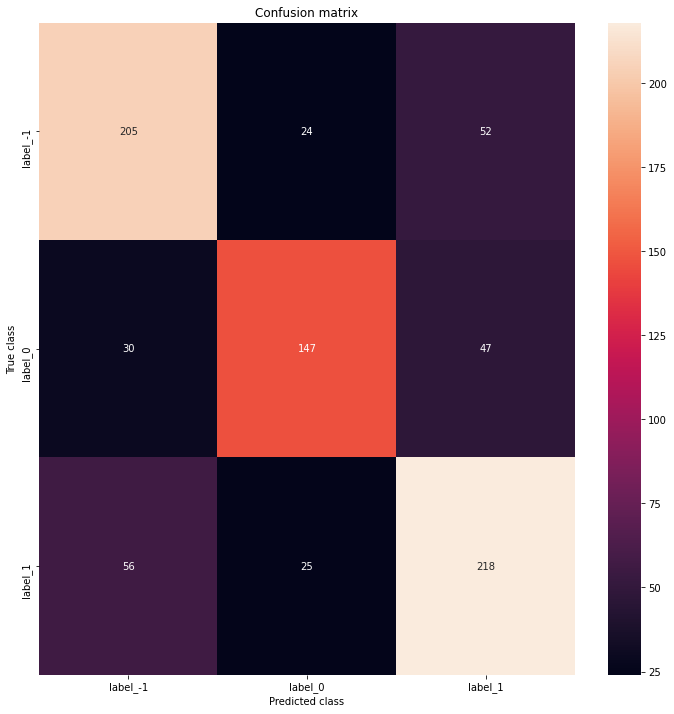

In [34]:
#creating and displaying confusion matrix
LABELS = ['label_-1', 'label_0', 'label_1']
conf_matrix = confusion_matrix(y_test, Pred_Y)
plt.figure(figsize=(12, 12))
sb.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [35]:
#generating and printing a classification report
print(classification_report(y_test, Pred_Y))

              precision    recall  f1-score   support

          -1       0.70      0.73      0.72       281
           0       0.75      0.66      0.70       224
           1       0.69      0.73      0.71       299

    accuracy                           0.71       804
   macro avg       0.71      0.70      0.71       804
weighted avg       0.71      0.71      0.71       804



In [36]:
print("Accuracy score: ", accuracy_score(y_test,Pred_Y))

Accuracy score:  0.7089552238805971


In [37]:
wrong_classified_Raw = Pred_Y != y_test

In [38]:
wrong_classified_Raw

0       True
1      False
2      False
3      False
4       True
       ...  
799     True
800    False
801     True
802    False
803    False
Name: label, Length: 804, dtype: bool

In [40]:
wrong_data_Raw = dfTest_Raw[wrong_classified_Raw == True]
wrong_labels_Raw = Pred_Y[wrong_classified_Raw == True]

In [42]:
false_pronet_Raw = wrong_data_Raw[wrong_labels_Raw == 1]

In [43]:
false_pronet_Raw

,tweet,label
0,Aspek historis calon ibu kota negara Kutai Ka...,0
4,Negara dikelola secara sporadis.. #pemindahani...,0
6,Mudah2an biaya pemindahan ibu kota tidak menja...,-1
7,Pemindahan ibu kota ke Kalimantan Timur bagaim...,0
16,pemindahan ibu kota bukan solusi justru menamb...,-1
...,...,...
696,Di rak saya ini ternyata ada buku pak Demokra...,-1
717,"Fabby Tumiwa menilai, pemindahan Ibu Kota baru...",-1
759,"Secara Geopolitik, Pemindahan Ibu Kota Negara ...",-1
791,Pemindahan ibu kota ke Kaltim akan turunkan ak...,-1


In [44]:
false_procon_Raw = wrong_data_Raw[wrong_labels_Raw == 0]

In [45]:
false_procon_Raw

,tweet,label
12,"Abis ngumumin pemindahan ibu kota negara, bias...",-1
24,Dipetimbangkan untuk menambah utang gitu maksu...,-1
40,"""Jaringan Advokasi Tambang (JATAM) memperkirak...",-1
53,Masyarakat Gunung Mas diminta hormati keputusa...,1
65,Jokowi sudah memutuskan pemindahan ibu kota ba...,1
78,Tahap Awal Pemindahan Ibu Kota Dimulai Tahun 2...,1
87,Maksudnya? Dalam pengumuman Presiden tadi jela...,1
99,Kesimpulan dan data Kajian dari kementrian ata...,-1
100,mewawancarai para kepala daerah di sepenju...,1
126,TAK DISANGKA PEMINDAHAN IBU KOTA MEMBUTUHKAN D...,-1


In [46]:
len(false_procon_Raw)

49

In [47]:
false_netcon_Raw = wrong_data_Raw[wrong_labels_Raw == -1]

In [48]:
false_netcon_Raw

,tweet,label
13,Kakak dapid td lg meeting pemindahan ibu kota ...,0
14,bapak tdk menolak tp bapak cuma menjelaskan ka...,0
19,Terkait rencana pemindahan Ibu Kota di kaliman...,1
22,Masih ngebayangin gmna proses pemindahan ibu k...,0
33,Terpecah belah cuma gara gara kepentingan poli...,0
...,...,...
773,Bukankah pemindahan ibu kota adalah cita2 Bung...,1
796,"Pemindahan Ibu kota, Amien Rais Caper! #pdip...",0
797,Pemindahan Ibu Kota RI dari Perspektif Pertaha...,0
799,Fadli Zon Pertanyakan Urgensi Pemindahan Ibu K...,0


# dfRaw Feature Selection

In [ ]:
from sklearn.feature_selection import SelectKBest, chi2

In [49]:

ch = SelectKBest(chi2)
clf = svm.SVC()
# tfidf = TfidfVectorizer()

#constructing the pipeline
pipe = Pipeline([
    # ('tfidf', tfidf),
    ('chi2', ch),
    ('clf', clf)
])

para = {"chi2__k" : np.arange(50, 3100, 200)}

estimator = GridSearchCV(pipe,para)
estimator.fit(Train_X_Tfidf.toarray(), y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('chi2',
                                        SelectKBest(k=10,
                                                    score_func=<function chi2 at 0x7f06b3b722f0>)),
                                       ('clf',
                                        SVC(C=1.0, break_ties=False,
                                            cache_size=200, class_weight=None,
                                            coef0=0.0,
                                            decision_function_shape='ovr',
                                            degree=3, gamma='scale',
                                            kernel='rbf', max_iter=-1,
                                            probability=False,
                                            random_state=None, shrinking=True,
                                            tol=0.001, verbose=False))],
                              

In [50]:
score = estimator.best_score_
estimator.best_params_

{'chi2__k': 650}

In [51]:
print ("Select feature for training set via Chi2 ...")

ch = SelectKBest(chi2, k=650)


x_train_feature_selected=ch.fit_transform(Train_X_Tfidf, y_train)
print ("Select feature for testset via Chi2 ...")
x_test_chi_selected = ch.transform(Test_X_Tfidf)
print ("Finished")

Select feature for training set via Chi2 ...
Select feature for testset via Chi2 ...
Finished


In [52]:
# Classifier - Algorithm - SVM
# fit the training dataset on the classifier
SVM = svm.SVC(kernel = 'linear')
SVM.fit(x_train_feature_selected, y_train)


# Use accuracy_score function to get the accuracy
print("SVM Training Accuracy Score -> ", SVM.score(x_train_feature_selected, y_train)*100)
print("SVM Testing Accuracy Score -> ", SVM.score(x_test_chi_selected, y_test)*100)

SVM Training Accuracy Score ->  78.57142857142857
SVM Testing Accuracy Score ->  68.03482587064677


In [53]:
ch = SelectKBest(chi2, k=650)
clf = svm.SVC()
tfidf = TfidfVectorizer()

pipe = Pipeline([
    ('tfidf', tfidf),
    ('chi2', ch),
    ('clf', clf)
])

In [54]:
linear_grid = {'tfidf__max_features': [500, 1000, 5000, None],
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'clf__C': np.logspace(-1, 3, 5),
    'clf__kernel' : ['linear']}
    
poly_grid = {'tfidf__max_features': [500, 1000, 5000, None],
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'clf__C': np.logspace(-1, 3, 5),
    'clf__kernel' : ['poly'],
    'clf__degree' : [2, 3],
    'clf__gamma': np.logspace(-2, 2, 5)}

rbf_grid = {'tfidf__max_features': [500, 1000, 5000, None],
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'clf__C': np.logspace(-1, 3, 5),
    'clf__kernel' : ['rbf'],
    'clf__gamma': np.logspace(-2, 2, 5)}

In [55]:
scv_linear = RandomizedSearchCV(pipe, param_distributions = linear_grid, n_iter = 10, cv = 5, verbose = 2, n_jobs = -1, return_train_score = True, random_state = 42)
scv_linear.fit(X_train, y_train);

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   13.7s finished


In [56]:
#using a randomized grid search to find the optimal value of the hyperparameters over a 5-fold cross-validation
scv_poly = RandomizedSearchCV(pipe, param_distributions = poly_grid, n_iter = 10, cv = 5, verbose = 2, n_jobs = -1, return_train_score = True, random_state = 42)
scv_poly.fit(X_train, y_train);

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   40.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   42.4s finished


In [57]:
#using a randomized grid search to find the optimal value of the hyperparameters over a 5-fold cross-validation
scv_rbf = RandomizedSearchCV(pipe, param_distributions = rbf_grid, n_iter = 10, cv = 5, verbose = 2, n_jobs = -1, return_train_score = True, random_state = 42)
scv_rbf.fit(X_train, y_train);

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   22.2s finished


In [58]:
#preview the best parameters as found by the gridsearch
scv_linear.best_params_

{'clf__C': 10.0,
 'clf__kernel': 'linear',
 'tfidf__max_features': None,
 'tfidf__ngram_range': (1, 1)}

In [59]:
#preview the best parameters as found by the gridsearch
scv_poly.best_params_

{'clf__C': 10.0,
 'clf__degree': 2,
 'clf__gamma': 10.0,
 'clf__kernel': 'poly',
 'tfidf__max_features': 5000,
 'tfidf__ngram_range': (1, 3)}

In [60]:
#preview the best parameters as found by the gridsearch
scv_rbf.best_params_

{'clf__C': 10.0,
 'clf__gamma': 1.0,
 'clf__kernel': 'rbf',
 'tfidf__max_features': 5000,
 'tfidf__ngram_range': (1, 3)}

In [61]:
scv_linear.best_estimator_

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='...
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('chi2',
                 SelectKBest(k=650,
                             score_func=<function chi2 at 0x7f06b3b722f0>)),
                ('clf',
                 SVC(C=10

In [62]:
scv_poly.best_estimator_

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=5000,
                                 min_df=1, ngram_range=(1, 3), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='...
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('chi2',
                 SelectKBest(k=650,
                             score_func=<function chi2 at 0x7f06b3b722f0>)),
                ('clf',
                 SVC(C=10

In [63]:
scv_rbf.best_estimator_

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=5000,
                                 min_df=1, ngram_range=(1, 3), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='...
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('chi2',
                 SelectKBest(k=650,
                             score_func=<function chi2 at 0x7f06b3b722f0>)),
                ('clf',
                 SVC(C=10

In [64]:
# Use accuracy_score function to get the accuracy
print("SVM Training Accuracy Score with chi square -> ", scv_linear.best_estimator_.score(X_train, y_train)*100)
print("SVM Testing Accuracy Score with chi square -> ", scv_linear.best_estimator_.score(X_test, y_test)*100)

SVM Training Accuracy Score with chi square ->  85.28784648187633
SVM Testing Accuracy Score with chi square ->  65.54726368159204


In [65]:
# Use accuracy_score function to get the accuracy
print("SVM Training Accuracy Score with chi square -> ", scv_poly.best_estimator_.score(X_train, y_train)*100)
print("SVM Testing Accuracy Score with chi square -> ", scv_poly.best_estimator_.score(X_test, y_test)*100)

SVM Training Accuracy Score with chi square ->  88.64605543710022
SVM Testing Accuracy Score with chi square ->  59.452736318407965


In [66]:
# Use accuracy_score function to get the accuracy
print("SVM Training Accuracy Score with chi square -> ", scv_rbf.best_estimator_.score(X_train, y_train)*100)
print("SVM Testing Accuracy Score with chi square -> ", scv_rbf.best_estimator_.score(X_test, y_test)*100)

SVM Training Accuracy Score with chi square ->  79.95735607675905
SVM Testing Accuracy Score with chi square ->  63.93034825870647


In [67]:
#selecting the classifier with the hyperparameters yielding the highest average cross-validation score
best_clfchi = scv_linear.best_estimator_

In [68]:
#obtaining predictions and decision function scores
Pred_Ychi = best_clfchi.predict(X_test)
Score_Ychi = best_clfchi.decision_function(X_test)

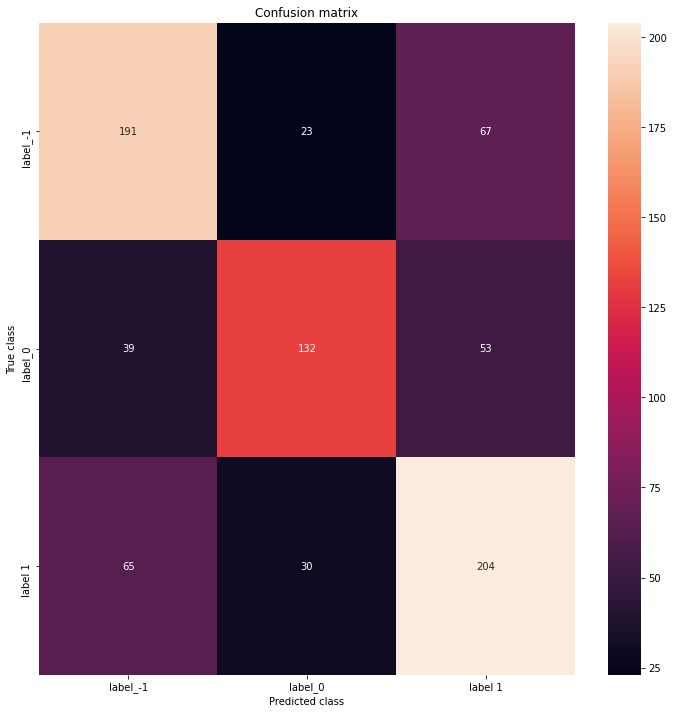

In [69]:
#creating and displaying confusion matrix
LABELS = ['label_-1', 'label_0', 'label 1']
conf_matrix = confusion_matrix(y_test, Pred_Ychi)
plt.figure(figsize=(12, 12))
sb.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [70]:
#generating and printing a classification report
print(classification_report(y_test, Pred_Ychi))

              precision    recall  f1-score   support

          -1       0.65      0.68      0.66       281
           0       0.71      0.59      0.65       224
           1       0.63      0.68      0.65       299

    accuracy                           0.66       804
   macro avg       0.66      0.65      0.65       804
weighted avg       0.66      0.66      0.66       804



In [71]:
print("Accuracy score with chi square: ", accuracy_score(y_test,Pred_Ychi))

Accuracy score with chi square:  0.6554726368159204


In [72]:
wrong_classified_Raw_Chi = Pred_Ychi != y_test

In [73]:
wrong_classified_Raw_Chi

0       True
1      False
2      False
3      False
4       True
       ...  
799     True
800    False
801    False
802    False
803    False
Name: label, Length: 804, dtype: bool

In [74]:
wrong_data_Raw_Chi = dfTest_Raw[wrong_classified_Raw_Chi == True]
wrong_labels_Raw_Chi = Pred_Ychi[wrong_classified_Raw_Chi == True]

In [75]:
false_pronet_Raw_Chi = wrong_data_Raw_Chi[wrong_labels_Raw_Chi == 1]

In [76]:
false_pronet_Raw_Chi

,tweet,label
0,Aspek historis calon ibu kota negara Kutai Ka...,0
4,Negara dikelola secara sporadis.. #pemindahani...,0
6,Mudah2an biaya pemindahan ibu kota tidak menja...,-1
7,Pemindahan ibu kota ke Kalimantan Timur bagaim...,0
8,Ada beberapa aspek yang dikaji dalam pemindaha...,0
...,...,...
783,"Soal Pemindahan Ibu Kota ke Kaltim , Amien Rai...",0
791,Pemindahan ibu kota ke Kaltim akan turunkan ak...,-1
793,Amien Rais: Pemerintah Menunggu Kajian Tiongko...,-1
795,Survei Median: Mayoritas Tolak Ibu Kota Pindah...,-1


In [77]:
false_procon_Raw_Chi = wrong_data_Raw_Chi[wrong_labels_Raw_Chi == 0]
false_procon_Raw_Chi

,tweet,label
32,Sepertinya ada sesuatu yang besar yang sengaja...,-1
47,Para pelaku usaha meminta agar pemindahan Ibu ...,1
52,APBN akan membiayai pemindahan ibu kota ke Kal...,1
55,MOHON DIKAJI LAGI !! 🤔 Kabid Mitigasi Gempa d...,-1
71,apakah pemindahan ibu kota itu tanpa biaya? ji...,-1
75,"""Pemindahan ibu kota juga menafikan masalah li...",1
78,Tahap Awal Pemindahan Ibu Kota Dimulai Tahun 2...,1
80,Presiden Joko Widodo menyampaikan kebutuhan bi...,1
99,Kesimpulan dan data Kajian dari kementrian ata...,-1
100,mewawancarai para kepala daerah di sepenju...,1


In [78]:
len(false_procon_Raw_Chi)

53

In [79]:
false_netcon_Raw_Chi = wrong_data_Raw_Chi[wrong_labels_Raw_Chi == -1]
false_netcon_Raw_Chi

,tweet,label
14,bapak tdk menolak tp bapak cuma menjelaskan ka...,0
19,Terkait rencana pemindahan Ibu Kota di kaliman...,1
22,Masih ngebayangin gmna proses pemindahan ibu k...,0
29,Skema Pembiayan Pemindahan Ibu Kota Negara ...,0
33,Terpecah belah cuma gara gara kepentingan poli...,0
...,...,...
767,Amien Rais bahas rencana pemindahan ibu kota.....,0
770,Pemindahan ibu kota ini tidak serta merta berl...,0
773,Bukankah pemindahan ibu kota adalah cita2 Bung...,1
796,"Pemindahan Ibu kota, Amien Rais Caper! #pdip...",0


# dfRawStem

In [80]:
# defining predictor and target features
X_trainRawStem = dfTrain_RawStem['tweet']
y_trainRawStem = dfTrain_RawStem['label']

X_testRawStem = dfTest_RawStem['tweet']
y_testRawStem = dfTest_RawStem['label']

In [81]:
#encoding the corpus using Term Frequency - Inverse Document Frequency Encoding
Tfidf_vect = TfidfVectorizer()

In [82]:
#fitting encoder on training data
Tfidf_vect.fit(X_trainRawStem)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [83]:
#Transforming the corpus for the training and testing data
Train_XRawStem_Tfidf = Tfidf_vect.transform(X_trainRawStem)
Test_XRawStem_Tfidf = Tfidf_vect.transform(X_testRawStem)

In [84]:
#preview vocabulary vector
print(Tfidf_vect.vocabulary_)

{'teliti': 4214, 'presiden': 3357, 'perlu': 3212, 'bentuk': 586, 'badan': 444, 'otorita': 3040, 'pindah': 3261, 'ibu': 1612, 'kota': 2241, 'antara': 340, 'news': 2856, 'berita': 607, 'kini': 2124, 'bangun': 490, 'pltn': 3292, 'di': 1018, 'kalbar': 1942, 'mantap': 2538, 'negara': 2847, 'prabowo': 3344, 'tuju': 4391, 'karena': 1984, 'sudah': 4056, 'jadi': 1781, 'usul': 4496, 'rencana': 3536, 'jangka': 1805, 'panjang': 3097, 'gerindra': 1383, 'sejak': 3774, '2014': 47, 'bukti': 759, 'jokowi': 1884, 'ingin': 1704, 'ada': 185, 'perata': 3193, 'lah': 2313, 'itu': 1760, 'kan': 1968, 'sdh': 3746, 'mau': 2584, 'ringan': 3581, 'dg': 1012, 'perintah': 3205, 'lebih': 2368, 'paham': 3063, 'biaya': 641, 'ri': 3568, 'dari': 941, 'pada': 3054, 'anda': 316, 'ngurusin': 2904, 'oke': 2998, 'oce': 2987, 'nga': 2857, 'becus': 546, 'tidak': 4279, 'usa': 4485, 'bicara': 642, 'kalau': 1941, 'tudak': 4384, 'tau': 4183, 'masalah': 2563, 'rakyat': 3465, 'masih': 2565, 'banyak': 500, 'keluh': 2042, 'tapi': 4171, 

In [85]:
#preview transformed training data
print(Train_XRawStem_Tfidf)

  (0, 4214)	0.38292088969282384
  (0, 3357)	0.19797363906940038
  (0, 3261)	0.057434697808089755
  (0, 3212)	0.25715289523757895
  (0, 3040)	0.39327045124353865
  (0, 2856)	0.2975412896679783
  (0, 2241)	0.0570078880537916
  (0, 2124)	0.348513330227804
  (0, 1612)	0.05703826826853653
  (0, 607)	0.2660756024596806
  (0, 586)	0.2954768647123143
  (0, 444)	0.348513330227804
  (0, 340)	0.3066432091301581
  (1, 3292)	0.4138819277533556
  (1, 3261)	0.0585587576796458
  (1, 2856)	0.30336449822675476
  (1, 2847)	0.16656523468626247
  (1, 2538)	0.390415070432182
  (1, 2241)	0.0581235947915121
  (1, 2124)	0.355334117385428
  (1, 1942)	0.4138819277533556
  (1, 1612)	0.058154569580296536
  (1, 1018)	0.14793297249076118
  (1, 607)	0.27128299309529214
  (1, 490)	0.23564499636957995
  :	:
  (1874, 3261)	0.036408743310501576
  (1874, 3191)	0.25732992750399875
  (1874, 3109)	0.13464096650629828
  (1874, 2241)	0.03613818200558128
  (1874, 1612)	0.036157440493613406
  (1874, 1589)	0.4854789495938189
  (1

In [86]:
# Classifier - Algorithm - SVM
# fit the training dataset on the classifier
SVM = svm.SVC(kernel = 'linear')
SVM.fit(Train_XRawStem_Tfidf, y_trainRawStem)

# Use accuracy_score function to get the accuracy
print("SVM Training Accuracy Score -> ", SVM.score(Train_XRawStem_Tfidf, y_trainRawStem)*100)
print("SVM Testing Accuracy Score -> ", SVM.score(Test_XRawStem_Tfidf, y_testRawStem)*100)

SVM Training Accuracy Score ->  93.28358208955224
SVM Testing Accuracy Score ->  70.64676616915423


In [87]:
#initializing tfidf vectorizer and an SVM classifier instance
tfidf = TfidfVectorizer()
clf = svm.SVC()

In [88]:
#constructing the pipeline
pipe = Pipeline([
    ('tfidf', tfidf),
    ('clf', clf)
])

In [89]:
linear_grid = {'tfidf__max_features': [500, 1000, 5000, None],
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'clf__C': np.logspace(-1, 3, 5),
    'clf__kernel' : ['linear']}
    
poly_grid = {'tfidf__max_features': [500, 1000, 5000, None],
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'clf__C': np.logspace(-1, 3, 5),
    'clf__kernel' : ['poly'],
    'clf__degree' : [2, 3],
    'clf__gamma': np.logspace(-2, 2, 5)}

rbf_grid = {'tfidf__max_features': [500, 1000, 5000, None],
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'clf__C': np.logspace(-1, 3, 5),
    'clf__kernel' : ['rbf'],
    'clf__gamma': np.logspace(-2, 2, 5)}

In [90]:
scv_linear = RandomizedSearchCV(pipe, param_distributions = linear_grid, n_iter = 10, cv = 5, verbose = 2, n_jobs = -1, return_train_score = True, random_state = 42)
scv_linear.fit(X_trainRawStem, y_trainRawStem);

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   27.7s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   36.7s finished


In [91]:
#using a randomized grid search to find the optimal value of the hyperparameters over a 5-fold cross-validation
scv_poly = RandomizedSearchCV(pipe, param_distributions = poly_grid, n_iter = 10, cv = 5, verbose = 2, n_jobs = -1, return_train_score = True, random_state = 42)
scv_poly.fit(X_trainRawStem, y_trainRawStem);

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   39.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   49.9s finished


In [92]:
#using a randomized grid search to find the optimal value of the hyperparameters over a 5-fold cross-validation
scv_rbf = RandomizedSearchCV(pipe, param_distributions = rbf_grid, n_iter = 10, cv = 5, verbose = 2, n_jobs = -1, return_train_score = True, random_state = 42)
scv_rbf.fit(X_trainRawStem, y_trainRawStem);

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   43.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   57.9s finished


In [93]:
#preview randomized gridsearch results
pd.DataFrame(scv_linear.cv_results_)[['params', 'mean_train_score', 'mean_test_score']]

,params,mean_train_score,mean_test_score
0,"{'tfidf__ngram_range': (1, 1), 'tfidf__max_fea...",0.643259,0.541597
1,"{'tfidf__ngram_range': (1, 3), 'tfidf__max_fea...",0.635264,0.527207
2,"{'tfidf__ngram_range': (1, 1), 'tfidf__max_fea...",0.982942,0.528271
3,"{'tfidf__ngram_range': (1, 1), 'tfidf__max_fea...",0.997868,0.603957
4,"{'tfidf__ngram_range': (1, 2), 'tfidf__max_fea...",0.806237,0.589058
5,"{'tfidf__ngram_range': (1, 1), 'tfidf__max_fea...",0.997868,0.604489
6,"{'tfidf__ngram_range': (1, 1), 'tfidf__max_fea...",0.995469,0.616750
7,"{'tfidf__ngram_range': (1, 1), 'tfidf__max_fea...",0.991471,0.525606
8,"{'tfidf__ngram_range': (1, 1), 'tfidf__max_fea...",0.822896,0.614099
9,"{'tfidf__ngram_range': (1, 1), 'tfidf__max_fea...",0.997868,0.604489


In [94]:
pd.DataFrame(scv_poly.cv_results_)[['params', 'mean_train_score', 'mean_test_score']]

,params,mean_train_score,mean_test_score
0,"{'tfidf__ngram_range': (1, 3), 'tfidf__max_fea...",0.990672,0.585848
1,"{'tfidf__ngram_range': (1, 3), 'tfidf__max_fea...",0.997868,0.595441
2,"{'tfidf__ngram_range': (1, 2), 'tfidf__max_fea...",0.991604,0.599179
3,"{'tfidf__ngram_range': (1, 3), 'tfidf__max_fea...",0.360874,0.360874
4,"{'tfidf__ngram_range': (1, 2), 'tfidf__max_fea...",0.360874,0.360874
5,"{'tfidf__ngram_range': (1, 3), 'tfidf__max_fea...",0.996402,0.614092
6,"{'tfidf__ngram_range': (1, 2), 'tfidf__max_fea...",0.360874,0.360874
7,"{'tfidf__ngram_range': (1, 2), 'tfidf__max_fea...",0.991604,0.599179
8,"{'tfidf__ngram_range': (1, 1), 'tfidf__max_fea...",0.360874,0.360874
9,"{'tfidf__ngram_range': (1, 2), 'tfidf__max_fea...",0.991604,0.599179


In [95]:
pd.DataFrame(scv_rbf.cv_results_)[['params', 'mean_train_score', 'mean_test_score']]

,params,mean_train_score,mean_test_score
0,"{'tfidf__ngram_range': (1, 3), 'tfidf__max_fea...",0.997868,0.625298
1,"{'tfidf__ngram_range': (1, 3), 'tfidf__max_fea...",0.990672,0.595973
2,"{'tfidf__ngram_range': (1, 3), 'tfidf__max_fea...",0.995736,0.625287
3,"{'tfidf__ngram_range': (1, 1), 'tfidf__max_fea...",0.360874,0.360874
4,"{'tfidf__ngram_range': (1, 3), 'tfidf__max_fea...",0.993603,0.369936
5,"{'tfidf__ngram_range': (1, 2), 'tfidf__max_fea...",0.997868,0.389660
6,"{'tfidf__ngram_range': (1, 2), 'tfidf__max_fea...",0.992137,0.569312
7,"{'tfidf__ngram_range': (1, 2), 'tfidf__max_fea...",0.991604,0.375270
8,"{'tfidf__ngram_range': (1, 3), 'tfidf__max_fea...",0.360874,0.360874
9,"{'tfidf__ngram_range': (1, 2), 'tfidf__max_fea...",0.997068,0.368338


In [96]:
#preview the best parameters as found by the gridsearch
scv_linear.best_params_

{'clf__C': 10.0,
 'clf__kernel': 'linear',
 'tfidf__max_features': None,
 'tfidf__ngram_range': (1, 1)}

In [97]:
#preview the best parameters as found by the gridsearch
scv_poly.best_params_

{'clf__C': 10.0,
 'clf__degree': 2,
 'clf__gamma': 10.0,
 'clf__kernel': 'poly',
 'tfidf__max_features': 5000,
 'tfidf__ngram_range': (1, 3)}

In [98]:
#preview the best parameters as found by the gridsearch
scv_rbf.best_params_

{'clf__C': 100.0,
 'clf__gamma': 0.1,
 'clf__kernel': 'rbf',
 'tfidf__max_features': None,
 'tfidf__ngram_range': (1, 3)}

In [99]:
scv_linear.best_estimator_

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 SVC(C=10.0, break_ties=False, cache_size=200,
                     class_weight=None, coef0=0.0,
                     decision_fun

In [100]:
scv_poly.best_estimator_

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=5000,
                                 min_df=1, ngram_range=(1, 3), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 SVC(C=10.0, break_ties=False, cache_size=200,
                     class_weight=None, coef0=0.0,
                     decision_fun

In [101]:
scv_rbf.best_estimator_

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 3), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 SVC(C=100.0, break_ties=False, cache_size=200,
                     class_weight=None, coef0=0.0,
                     decision_fu

In [102]:
# Use accuracy_score function to get the accuracy
print("SVM Training Accuracy Score -> ", scv_linear.best_estimator_.score(X_trainRawStem, y_trainRawStem)*100)
print("SVM Testing Accuracy Score -> ", scv_linear.best_estimator_.score(X_testRawStem, y_testRawStem)*100)

SVM Training Accuracy Score ->  99.52025586353945
SVM Testing Accuracy Score ->  69.77611940298507


In [103]:
# Use accuracy_score function to get the accuracy
print("SVM Training Accuracy Score -> ", scv_poly.best_estimator_.score(X_trainRawStem, y_trainRawStem)*100)
print("SVM Testing Accuracy Score -> ", scv_poly.best_estimator_.score(X_testRawStem, y_testRawStem)*100)

SVM Training Accuracy Score ->  99.6268656716418
SVM Testing Accuracy Score ->  69.90049751243781


In [104]:
# Use accuracy_score function to get the accuracy
print("SVM Training Accuracy Score -> ", scv_rbf.best_estimator_.score(X_trainRawStem, y_trainRawStem)*100)
print("SVM Testing Accuracy Score -> ", scv_rbf.best_estimator_.score(X_testRawStem, y_testRawStem)*100)

SVM Training Accuracy Score ->  99.7867803837953
SVM Testing Accuracy Score ->  72.01492537313433


In [105]:
#selecting the classifier with the hyperparameters yielding the highest average cross-validation score
best_clf = scv_rbf.best_estimator_

In [106]:
#obtaining predictions and decision function scores
Pred_YRawStem = best_clf.predict(X_testRawStem)
Score_YRawStem = best_clf.decision_function(X_testRawStem)

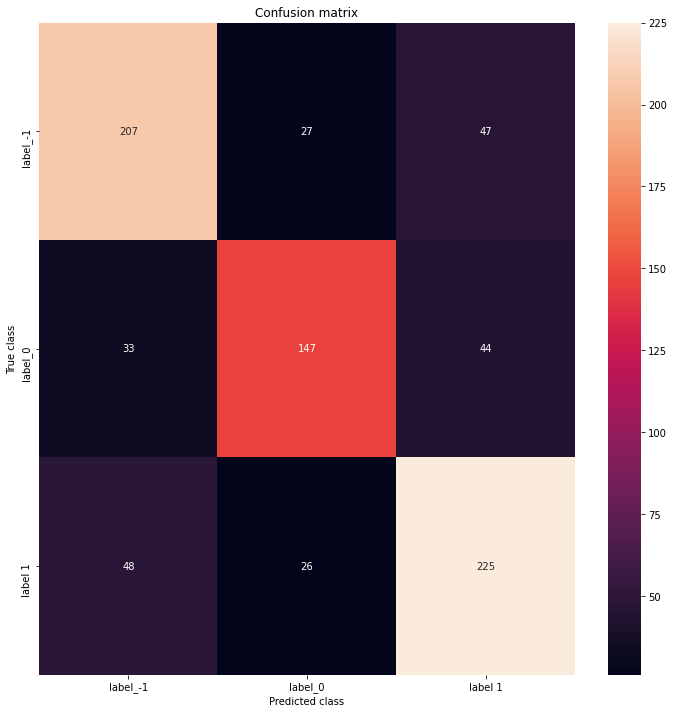

In [107]:
#creating and displaying confusion matrix
LABELS = ['label_-1', 'label_0', 'label 1']
conf_matrix = confusion_matrix(y_testRawStem, Pred_YRawStem)
plt.figure(figsize=(12, 12))
sb.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [108]:
#generating and printing a classification report
print(classification_report(y_testRawStem, Pred_YRawStem))

              precision    recall  f1-score   support

          -1       0.72      0.74      0.73       281
           0       0.73      0.66      0.69       224
           1       0.71      0.75      0.73       299

    accuracy                           0.72       804
   macro avg       0.72      0.72      0.72       804
weighted avg       0.72      0.72      0.72       804



In [109]:
print("Accuracy score: ", accuracy_score(y_testRawStem,Pred_YRawStem))

Accuracy score:  0.7201492537313433


In [112]:
wrong_classified_RawStem = Pred_YRawStem != y_testRawStem

In [113]:
wrong_classified_RawStem

0       True
1      False
2      False
3      False
4       True
       ...  
799    False
800    False
801     True
802    False
803    False
Name: label, Length: 804, dtype: bool

In [114]:
wrong_data_RawStem = dfTest_RawStem[wrong_classified_RawStem == True]
wrong_labels_RawStem = Pred_YRawStem[wrong_classified_RawStem == True]

In [115]:
false_pronet_RawStem = wrong_data_RawStem[wrong_labels_RawStem == 1]
false_pronet_RawStem

,tweet,label
0,aspek historis calon ibu kota negara kuta kart...,0
4,negara kelola cara sporadis pemindahanibukota,0
6,mudah2an biaya pindah ibu kota tidak jadi ajan...,-1
7,pindah ibu kota ke kalimantan timur bagaimana ...,0
16,pindah ibu kota bukan solusi justru tambah mas...,-1
...,...,...
717,fabby tumiwa nilai pindah ibu kota baru di kal...,-1
759,cara geopolitik pindah ibu kota negara sangat ...,-1
783,soal pindah ibu kota ke kaltim amien rais kel...,0
791,pindah ibu kota ke kaltim akan turun aktivitas...,-1


In [116]:
false_procon_RawStem = wrong_data_RawStem[wrong_labels_RawStem == 0]
false_procon_RawStem

,tweet,label
12,abis ngumumin pindah ibu kota negara biasa jaw...,-1
40,jaring advokasi tambang jatam kira pindah ibu ...,-1
52,apbn akan biaya pindah ibu kota ke kalimantan ...,1
53,masyarakat gunung mas minta hormat putus pinda...,1
65,jokowi sudah putus pindah ibu kota bakal tel d...,1
78,tahap awal pindah ibu kota mulai tahun 2020 ib...,1
80,presiden joko widodo sampai butuh biaya pindah...,1
87,maksud dalam umum presiden tadi jelas bahwa su...,1
99,simpul dan data kaji dari tri atau badan harus...,-1
100,wawancara para kepala daerah di penjuru kaltim...,1


In [117]:
len(false_procon_RawStem)

53

In [118]:
false_netcon_RawStem = wrong_data_RawStem[wrong_labels_RawStem == -1]
false_netcon_RawStem

,tweet,label
14,bapak tdk tolak tp bapak cuma jelas kakurangan...,0
17,pindah ibu kota trending di twitter lihat kome...,0
19,kait rencana pindah ibu kota di kalimantan ban...,1
22,masih ngebayangin gmna proses pindah ibu kota ...,0
25,ngomong apa kau lek sok jago kira mimpin negar...,0
...,...,...
770,pindah ibu kota ini tidak serta merta langsung...,0
773,bukankah pindah ibu kota adalah cita2 bung kar...,1
796,pindah ibu kota amien rais caper pdiperjuangan,0
797,pindah ibu kota ri dari perspektif tahan,0


# dfRawStem Feature Selection

In [119]:
chRawStem = SelectKBest(chi2)
clfRawStem = svm.SVC()
# tfidf = TfidfVectorizer()

#constructing the pipeline
pipeRawStem = Pipeline([
    # ('tfidf', tfidf),
    ('chi2', chRawStem),
    ('clf', clfRawStem)
])

para = {"chi2__k" : np.arange(50, 3100, 200)}

estimatoRawStem = GridSearchCV(pipeRawStem,para)
estimatoRawStem.fit(Train_XRawStem_Tfidf.toarray(), y_trainRawStem)

GridSearchCV(cv=None, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('chi2',
                                        SelectKBest(k=10,
                                                    score_func=<function chi2 at 0x7f06b3b722f0>)),
                                       ('clf',
                                        SVC(C=1.0, break_ties=False,
                                            cache_size=200, class_weight=None,
                                            coef0=0.0,
                                            decision_function_shape='ovr',
                                            degree=3, gamma='scale',
                                            kernel='rbf', max_iter=-1,
                                            probability=False,
                                            random_state=None, shrinking=True,
                                            tol=0.001, verbose=False))],
                              

In [121]:
scoreRawStem = estimatoRawStem.best_score_
bestRawStem = estimatoRawStem.best_params_

bestRawStem

{'chi2__k': 2850}

In [122]:
scoreRawStem

0.6258170212765958

In [123]:
print ("Select feature for training set via Chi2 ...")

chRawStem = SelectKBest(chi2, k=2850)


x_trainRawStem_feature_selected = chRawStem.fit_transform(Train_XRawStem_Tfidf, y_trainRawStem)
print ("Select feature for testset via Chi2 ...")
x_testRawStem_chi_selected = chRawStem.transform(Test_XRawStem_Tfidf)
print ("Finished")

Select feature for training set via Chi2 ...
Select feature for testset via Chi2 ...
Finished


In [124]:
# Classifier - Algorithm - SVM
# fit the training dataset on the classifier
SVMRawStem = svm.SVC(kernel = 'linear')
SVMRawStem.fit(x_trainRawStem_feature_selected, y_trainRawStem)


# Use accuracy_score function to get the accuracy
print("SVM Training Accuracy Score -> ", SVMRawStem.score(x_trainRawStem_feature_selected, y_trainRawStem)*100)
print("SVM Testing Accuracy Score -> ", SVMRawStem.score(x_testRawStem_chi_selected, y_testRawStem)*100)

SVM Training Accuracy Score ->  90.6183368869936
SVM Testing Accuracy Score ->  70.8955223880597


In [125]:
chRawStem = SelectKBest(chi2, k=2850)
clfRawStem = svm.SVC()
tfidfRawStem = TfidfVectorizer()

pipeRawStem = Pipeline([
    ('tfidf', tfidfRawStem),
    ('chi2', chRawStem),
    ('clf', clfRawStem)
])

In [126]:
linear_grid = {'tfidf__max_features': [500, 1000, 5000, None],
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'clf__C': np.logspace(-1, 3, 5),
    'clf__kernel' : ['linear']}
    
poly_grid = {'tfidf__max_features': [500, 1000, 5000, None],
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'clf__C': np.logspace(-1, 3, 5),
    'clf__kernel' : ['poly'],
    'clf__degree' : [2, 3],
    'clf__gamma': np.logspace(-2, 2, 5)}

rbf_grid = {'tfidf__max_features': [500, 1000, 5000, None],
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'clf__C': np.logspace(-1, 3, 5),
    'clf__kernel' : ['rbf'],
    'clf__gamma': np.logspace(-2, 2, 5)}

In [127]:
scv_linear = RandomizedSearchCV(pipeRawStem, param_distributions = linear_grid, n_iter = 10, cv = 5, verbose = 2, n_jobs = -1, return_train_score = True, random_state = 42)
scv_linear.fit(X_trainRawStem, y_trainRawStem);

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   14.0s finished


In [128]:
#using a randomized grid search to find the optimal value of the hyperparameters over a 5-fold cross-validation
scv_poly = RandomizedSearchCV(pipeRawStem, param_distributions = poly_grid, n_iter = 10, cv = 5, verbose = 2, n_jobs = -1, return_train_score = True, random_state = 42)
scv_poly.fit(X_trainRawStem, y_trainRawStem);

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   34.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   50.0s finished


In [129]:
 #using a randomized grid search to find the optimal value of the hyperparameters over a 5-fold cross-validation
scv_rbf = RandomizedSearchCV(pipeRawStem, param_distributions = rbf_grid, n_iter = 10, cv = 5, verbose = 2, n_jobs = -1, return_train_score = True, random_state = 42)
scv_rbf.fit(X_trainRawStem, y_trainRawStem);

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   21.4s finished


In [130]:
#preview the best parameters as found by the gridsearch
scv_linear.best_params_

{'clf__C': 10.0,
 'clf__kernel': 'linear',
 'tfidf__max_features': None,
 'tfidf__ngram_range': (1, 1)}

In [131]:
scv_poly.best_params_

{'clf__C': 10.0,
 'clf__degree': 2,
 'clf__gamma': 10.0,
 'clf__kernel': 'poly',
 'tfidf__max_features': 5000,
 'tfidf__ngram_range': (1, 3)}

In [132]:
scv_rbf.best_params_

{'clf__C': 10.0,
 'clf__gamma': 1.0,
 'clf__kernel': 'rbf',
 'tfidf__max_features': 5000,
 'tfidf__ngram_range': (1, 3)}

In [133]:
scv_linear.best_estimator_

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='...
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('chi2',
                 SelectKBest(k=2850,
                             score_func=<function chi2 at 0x7f06b3b722f0>)),
                ('clf',
                 SVC(C=1

In [134]:
scv_poly.best_estimator_

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=5000,
                                 min_df=1, ngram_range=(1, 3), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='...
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('chi2',
                 SelectKBest(k=2850,
                             score_func=<function chi2 at 0x7f06b3b722f0>)),
                ('clf',
                 SVC(C=1

In [135]:
scv_rbf.best_estimator_

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=5000,
                                 min_df=1, ngram_range=(1, 3), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='...
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('chi2',
                 SelectKBest(k=2850,
                             score_func=<function chi2 at 0x7f06b3b722f0>)),
                ('clf',
                 SVC(C=1

In [136]:
# Use accuracy_score function to get the accuracy
print("SVM Training Accuracy Score with chi square for data raw-> ", scv_linear.best_estimator_.score(X_trainRawStem, y_trainRawStem)*100)
print("SVM Testing Accuracy Score with chi square for data raw -> ", scv_linear.best_estimator_.score(X_testRawStem, y_testRawStem)*100)

SVM Training Accuracy Score with chi square for data raw->  98.88059701492537
SVM Testing Accuracy Score with chi square for data raw ->  66.54228855721394


In [137]:
# Use accuracy_score function to get the accuracy
print("SVM Training Accuracy Score with chi square for data raw-> ", scv_poly.best_estimator_.score(X_trainRawStem, y_trainRawStem)*100)
print("SVM Testing Accuracy Score with chi square for data raw -> ", scv_poly.best_estimator_.score(X_testRawStem, y_testRawStem)*100)

SVM Training Accuracy Score with chi square for data raw->  99.46695095948827
SVM Testing Accuracy Score with chi square for data raw ->  61.940298507462686


In [138]:
# Use accuracy_score function to get the accuracy
print("SVM Training Accuracy Score with chi square for data raw-> ", scv_rbf.best_estimator_.score(X_trainRawStem, y_trainRawStem)*100)
print("SVM Testing Accuracy Score with chi square for data raw -> ", scv_rbf.best_estimator_.score(X_testRawStem, y_testRawStem)*100)

SVM Training Accuracy Score with chi square for data raw->  99.09381663113007
SVM Testing Accuracy Score with chi square for data raw ->  66.29353233830845


In [139]:
#selecting the classifier with the hyperparameters yielding the highest average cross-validation score
best_clfchiRawStem = scv_linear.best_estimator_

In [140]:
#obtaining predictions and decision function scores
PredRawStem_Ychi = best_clfchiRawStem.predict(X_testRawStem)
ScoreRawStem_Ychi = best_clfchiRawStem.decision_function(X_testRawStem)

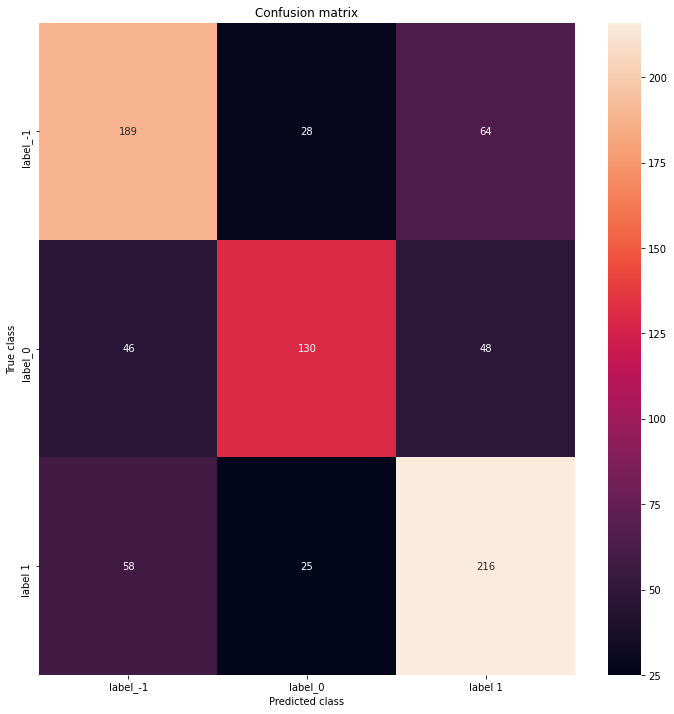

In [141]:
#creating and displaying confusion matrix
LABELS = ['label_-1', 'label_0', 'label 1']
conf_matrix = confusion_matrix(y_testRawStem, PredRawStem_Ychi)
plt.figure(figsize=(12, 12))
sb.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [142]:
#generating and printing a classification report
print(classification_report(y_testRawStem, PredRawStem_Ychi))

              precision    recall  f1-score   support

          -1       0.65      0.67      0.66       281
           0       0.71      0.58      0.64       224
           1       0.66      0.72      0.69       299

    accuracy                           0.67       804
   macro avg       0.67      0.66      0.66       804
weighted avg       0.67      0.67      0.66       804



In [143]:
print("Accuracy score with chi square data RawStem: ", accuracy_score(y_testRawStem,PredRawStem_Ychi))

Accuracy score with chi square data RawStem:  0.6654228855721394


In [144]:
wrong_classified_RawStem_Chi = PredRawStem_Ychi != y_testRawStem

In [145]:
wrong_classified_RawStem_Chi

0       True
1      False
2      False
3      False
4       True
       ...  
799     True
800     True
801     True
802    False
803    False
Name: label, Length: 804, dtype: bool

In [146]:
wrong_data_RawStem_Chi = dfTest_RawStem[wrong_classified_RawStem_Chi == True]
wrong_labels_RawStem_Chi = PredRawStem_Ychi[wrong_classified_RawStem_Chi == True]

In [147]:
false_pronet_RawStem_Chi = wrong_data_RawStem_Chi[wrong_labels_RawStem_Chi == 1]
false_pronet_RawStem_Chi

,tweet,label
0,aspek historis calon ibu kota negara kuta kart...,0
6,mudah2an biaya pindah ibu kota tidak jadi ajan...,-1
13,kakak dapid td lg meeting pindah ibu kota kata,0
16,pindah ibu kota bukan solusi justru tambah mas...,-1
17,pindah ibu kota trending di twitter lihat kome...,0
...,...,...
738,dualisme konseptual antara baik atau pindah ib...,0
772,taufid nilai pindah ibu kota justru potensi ha...,-1
791,pindah ibu kota ke kaltim akan turun aktivitas...,-1
793,amien rais perintah tunggu kaji tiongkok soal ...,-1


In [148]:
false_procon_RawStem_Chi = wrong_data_RawStem_Chi[wrong_labels_RawStem_Chi == 0]
false_procon_RawStem_Chi

,tweet,label
12,abis ngumumin pindah ibu kota negara biasa jaw...,-1
38,semua terlalu sibuk urusin pindah ibu kota ayo...,-1
53,masyarakat gunung mas minta hormat putus pinda...,1
55,mohon kaji lagi kabid mitigasi gempa dan tsu...,-1
78,tahap awal pindah ibu kota mulai tahun 2020 ib...,1
79,ketua dpr dukung pindah ibu kota ke kaltim,1
87,maksud dalam umum presiden tadi jelas bahwa su...,1
99,simpul dan data kaji dari tri atau badan harus...,-1
120,beban berat bkn pada jakarta sj pindah bukan s...,-1
121,tabrak undang republik indonesia nomor 29 tahu...,-1


In [149]:
len(false_procon_RawStem_Chi)

53

In [150]:
false_netcon_RawStem_Chi = wrong_data_RawStem_Chi[wrong_labels_RawStem_Chi == -1]
false_netcon_RawStem_Chi

,tweet,label
4,negara kelola cara sporadis pemindahanibukota,0
7,pindah ibu kota ke kalimantan timur bagaimana ...,0
14,bapak tdk tolak tp bapak cuma jelas kakurangan...,0
19,kait rencana pindah ibu kota di kalimantan ban...,1
22,masih ngebayangin gmna proses pindah ibu kota ...,0
...,...,...
796,pindah ibu kota amien rais caper pdiperjuangan,0
797,pindah ibu kota ri dari perspektif tahan,0
799,fadli zon tanya urgensi pindah ibu kota pic tw...,0
800,pindah ibu kota dengan skema investasi dari ju...,1


# dfPre

In [151]:
# defining predictor and target features
X_trainPre = dfTrain_Pre['tweet']
y_trainPre = dfTrain_Pre['label']

X_testPre = dfTest_Pre['tweet']
y_testPre = dfTest_Pre['label']

In [152]:
#encoding the corpus using Term Frequency - Inverse Document Frequency Encoding
Tfidf_vect = TfidfVectorizer()

In [153]:
#fitting encoder on training data
Tfidf_vect.fit(X_trainPre)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [154]:
#Transforming the corpus for the training and testing data
Train_XPre_Tfidf = Tfidf_vect.transform(X_trainPre)
Test_XPre_Tfidf = Tfidf_vect.transform(X_testPre)

In [155]:
#preview vocabulary vector
print(Tfidf_vect.vocabulary_)

{'peneliti': 3970, 'presiden': 4285, 'perlu': 4090, 'bentuk': 423, 'badan': 269, 'otorita': 3762, 'pemindahan': 3941, 'ibu': 1843, 'kota': 2585, 'news': 3573, 'berita': 503, 'terkini': 5249, 'pembangunan': 3903, 'pltn': 4216, 'kalbar': 2162, 'mantapkan': 2881, 'negara': 3562, 'prabowo': 4272, 'setuju': 4854, 'menjadi': 3246, 'usulan': 5546, 'rencana': 4465, 'jangka': 2017, 'panjang': 3815, 'gerindra': 1590, 'sejak': 4718, 'bukti': 723, 'jokowi': 2102, 'adanya': 21, 'pemerataan': 3925, 'lah': 2651, 'kan': 2186, 'sdh': 4664, 'mau': 2926, 'ringankan': 4507, 'dg': 970, 'sudahlah': 5034, 'pemerintah': 3928, 'lebih': 2703, 'paham': 3782, 'biaya': 607, 'ri': 4495, 'ngurusin': 3617, 'oke': 3721, 'oce': 3710, 'nga': 3574, 'becus': 380, 'usa': 5533, 'bicara': 609, 'kalau': 2161, 'tudak': 5417, 'tau': 5143, 'masalah': 2903, 'rakyatnya': 4398, 'banyak': 326, 'keluhan': 2321, 'pemerintahnya': 3930, 'sibuk': 4882, 'memang': 3000, 'benar': 414, 'jakarta': 2002, 'terlalu': 5252, 'berat': 443, 'menyoko

In [156]:
#preview transformed training data
print(Train_XPre_Tfidf)

  (0, 5249)	0.37305591183349796
  (0, 4285)	0.20296574071018994
  (0, 4090)	0.27726574626830236
  (0, 3970)	0.3896743214112314
  (0, 3941)	0.05872860320136525
  (0, 3762)	0.40020641428663906
  (0, 3573)	0.3095928366942644
  (0, 2585)	0.05801331473524204
  (0, 1843)	0.05804423075440869
  (0, 503)	0.29670259678892213
  (0, 423)	0.33301516947501447
  (0, 269)	0.35465992876030084
  (1, 5249)	0.38194788864841567
  (1, 4216)	0.4229430224034966
  (1, 3941)	0.06012842923675084
  (1, 3903)	0.26478457548368134
  (1, 3573)	0.3169721389345642
  (1, 3562)	0.1710419358593427
  (1, 2881)	0.4399575401998072
  (1, 2585)	0.0593960915073537
  (1, 2162)	0.4229430224034966
  (1, 1843)	0.05942774442551302
  (1, 503)	0.3037746536251384
  (2, 5546)	0.37566220290254565
  (2, 4854)	0.28532521612831563
  :	:
  (1873, 2269)	0.35073527863361675
  (1873, 1898)	0.17396637336067342
  (1873, 1843)	0.04928183087452527
  (1873, 834)	0.12511551048688302
  (1873, 748)	0.38473144099728707
  (1873, 125)	0.23094769427705078


In [157]:
# Classifier - Algorithm - SVM
# fit the training dataset on the classifier
SVM = svm.SVC(kernel = 'linear')
SVM.fit(Train_XPre_Tfidf, y_trainPre)

# Use accuracy_score function to get the accuracy
print("SVM Training Accuracy Score -> ", SVM.score(Train_XPre_Tfidf, y_trainPre)*100)
print("SVM Testing Accuracy Score -> ", SVM.score(Test_XPre_Tfidf, y_testPre)*100)

SVM Training Accuracy Score ->  95.41577825159915
SVM Testing Accuracy Score ->  70.77114427860697


In [158]:
#initializing tfidf vectorizer and an SVM classifier instance
tfidf = TfidfVectorizer()
clf = svm.SVC()

In [159]:
#constructing the pipeline
pipe = Pipeline([
    ('tfidf', tfidf),
    ('clf', clf)
])

In [160]:
linear_grid = {'tfidf__max_features': [500, 1000, 5000, None],
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'clf__C': np.logspace(-1, 3, 5),
    'clf__kernel' : ['linear']}
    
poly_grid = {'tfidf__max_features': [500, 1000, 5000, None],
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'clf__C': np.logspace(-1, 3, 5),
    'clf__kernel' : ['poly'],
    'clf__degree' : [2, 3],
    'clf__gamma': np.logspace(-2, 2, 5)}

rbf_grid = {'tfidf__max_features': [500, 1000, 5000, None],
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'clf__C': np.logspace(-1, 3, 5),
    'clf__kernel' : ['rbf'],
    'clf__gamma': np.logspace(-2, 2, 5)}

In [161]:
scv_linear = RandomizedSearchCV(pipe, param_distributions = linear_grid, n_iter = 10, cv = 5, verbose = 2, n_jobs = -1, return_train_score = True, random_state = 42)
scv_linear.fit(X_trainPre, y_trainPre);

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   24.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   33.8s finished


In [162]:
#using a randomized grid search to find the optimal value of the hyperparameters over a 5-fold cross-validation
scv_poly = RandomizedSearchCV(pipe, param_distributions = poly_grid, n_iter = 10, cv = 5, verbose = 2, n_jobs = -1, return_train_score = True, random_state = 42)
scv_poly.fit(X_trainPre, y_trainPre);

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   30.8s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   38.9s finished


In [163]:
#using a randomized grid search to find the optimal value of the hyperparameters over a 5-fold cross-validation
scv_rbf = RandomizedSearchCV(pipe, param_distributions = rbf_grid, n_iter = 10, cv = 5, verbose = 2, n_jobs = -1, return_train_score = True, random_state = 42)
scv_rbf.fit(X_trainPre, y_trainPre);

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   35.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   46.7s finished


In [164]:
#preview randomized gridsearch results
pd.DataFrame(scv_linear.cv_results_)[['params', 'mean_train_score', 'mean_test_score']]

,params,mean_train_score,mean_test_score
0,"{'tfidf__ngram_range': (1, 1), 'tfidf__max_fea...",0.625534,0.518138
1,"{'tfidf__ngram_range': (1, 3), 'tfidf__max_fea...",0.628998,0.518671
2,"{'tfidf__ngram_range': (1, 1), 'tfidf__max_fea...",0.961220,0.520826
3,"{'tfidf__ngram_range': (1, 1), 'tfidf__max_fea...",0.997068,0.580526
4,"{'tfidf__ngram_range': (1, 2), 'tfidf__max_fea...",0.781984,0.575184
5,"{'tfidf__ngram_range': (1, 1), 'tfidf__max_fea...",0.997068,0.581058
6,"{'tfidf__ngram_range': (1, 1), 'tfidf__max_fea...",0.995469,0.593305
7,"{'tfidf__ngram_range': (1, 1), 'tfidf__max_fea...",0.979610,0.510157
8,"{'tfidf__ngram_range': (1, 1), 'tfidf__max_fea...",0.799307,0.593298
9,"{'tfidf__ngram_range': (1, 1), 'tfidf__max_fea...",0.997068,0.580526


In [165]:
pd.DataFrame(scv_poly.cv_results_)[['params', 'mean_train_score', 'mean_test_score']]

,params,mean_train_score,mean_test_score
0,"{'tfidf__ngram_range': (1, 3), 'tfidf__max_fea...",0.980677,0.558115
1,"{'tfidf__ngram_range': (1, 3), 'tfidf__max_fea...",0.997068,0.593837
2,"{'tfidf__ngram_range': (1, 2), 'tfidf__max_fea...",0.981609,0.565051
3,"{'tfidf__ngram_range': (1, 3), 'tfidf__max_fea...",0.360874,0.360874
4,"{'tfidf__ngram_range': (1, 2), 'tfidf__max_fea...",0.360874,0.360874
5,"{'tfidf__ngram_range': (1, 3), 'tfidf__max_fea...",0.996269,0.595970
6,"{'tfidf__ngram_range': (1, 2), 'tfidf__max_fea...",0.360874,0.360874
7,"{'tfidf__ngram_range': (1, 2), 'tfidf__max_fea...",0.981609,0.565051
8,"{'tfidf__ngram_range': (1, 1), 'tfidf__max_fea...",0.360874,0.360874
9,"{'tfidf__ngram_range': (1, 2), 'tfidf__max_fea...",0.981609,0.565051


In [166]:
pd.DataFrame(scv_rbf.cv_results_)[['params', 'mean_train_score', 'mean_test_score']]

,params,mean_train_score,mean_test_score
0,"{'tfidf__ngram_range': (1, 3), 'tfidf__max_fea...",0.997068,0.615169
1,"{'tfidf__ngram_range': (1, 3), 'tfidf__max_fea...",0.980677,0.561851
2,"{'tfidf__ngram_range': (1, 3), 'tfidf__max_fea...",0.995735,0.603969
3,"{'tfidf__ngram_range': (1, 1), 'tfidf__max_fea...",0.360874,0.360874
4,"{'tfidf__ngram_range': (1, 3), 'tfidf__max_fea...",0.990405,0.379529
5,"{'tfidf__ngram_range': (1, 2), 'tfidf__max_fea...",0.997068,0.380593
6,"{'tfidf__ngram_range': (1, 2), 'tfidf__max_fea...",0.988273,0.552261
7,"{'tfidf__ngram_range': (1, 2), 'tfidf__max_fea...",0.981609,0.376871
8,"{'tfidf__ngram_range': (1, 3), 'tfidf__max_fea...",0.360874,0.360874
9,"{'tfidf__ngram_range': (1, 2), 'tfidf__max_fea...",0.996535,0.369401


In [167]:
#preview the best parameters as found by the gridsearch
scv_linear.best_params_

{'clf__C': 10.0,
 'clf__kernel': 'linear',
 'tfidf__max_features': None,
 'tfidf__ngram_range': (1, 1)}

In [168]:
#preview the best parameters as found by the gridsearch
scv_poly.best_params_

{'clf__C': 10.0,
 'clf__degree': 2,
 'clf__gamma': 10.0,
 'clf__kernel': 'poly',
 'tfidf__max_features': 5000,
 'tfidf__ngram_range': (1, 3)}

In [169]:
#preview the best parameters as found by the gridsearch
scv_rbf.best_params_

{'clf__C': 100.0,
 'clf__gamma': 0.1,
 'clf__kernel': 'rbf',
 'tfidf__max_features': None,
 'tfidf__ngram_range': (1, 3)}

In [170]:
scv_linear.best_estimator_

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 SVC(C=10.0, break_ties=False, cache_size=200,
                     class_weight=None, coef0=0.0,
                     decision_fun

In [171]:
scv_poly.best_estimator_

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=5000,
                                 min_df=1, ngram_range=(1, 3), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 SVC(C=10.0, break_ties=False, cache_size=200,
                     class_weight=None, coef0=0.0,
                     decision_fun

In [172]:
scv_rbf.best_estimator_

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 3), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 SVC(C=100.0, break_ties=False, cache_size=200,
                     class_weight=None, coef0=0.0,
                     decision_fu

In [173]:
# Use accuracy_score function to get the accuracy
print("SVM Training Accuracy Score -> ", scv_linear.best_estimator_.score(X_trainPre, y_trainPre)*100)
print("SVM Testing Accuracy Score -> ", scv_linear.best_estimator_.score(X_testPre, y_testPre)*100)

SVM Training Accuracy Score ->  99.52025586353945
SVM Testing Accuracy Score ->  69.27860696517413


In [174]:
# Use accuracy_score function to get the accuracy
print("SVM Training Accuracy Score -> ", scv_poly.best_estimator_.score(X_trainPre, y_trainPre)*100)
print("SVM Testing Accuracy Score -> ", scv_poly.best_estimator_.score(X_testPre, y_testPre)*100)

SVM Training Accuracy Score ->  99.52025586353945
SVM Testing Accuracy Score ->  70.1492537313433


In [175]:
# Use accuracy_score function to get the accuracy
print("SVM Training Accuracy Score -> ", scv_rbf.best_estimator_.score(X_trainPre, y_trainPre)*100)
print("SVM Testing Accuracy Score -> ", scv_rbf.best_estimator_.score(X_testPre, y_testPre)*100)

SVM Training Accuracy Score ->  99.68017057569296
SVM Testing Accuracy Score ->  71.14427860696517


In [176]:
#selecting the classifier with the hyperparameters yielding the highest average cross-validation score
best_clf = scv_rbf.best_estimator_

In [177]:
#obtaining predictions and decision function scores
Pred_YPre = best_clf.predict(X_testPre)
Score_YPre = best_clf.decision_function(X_testPre)

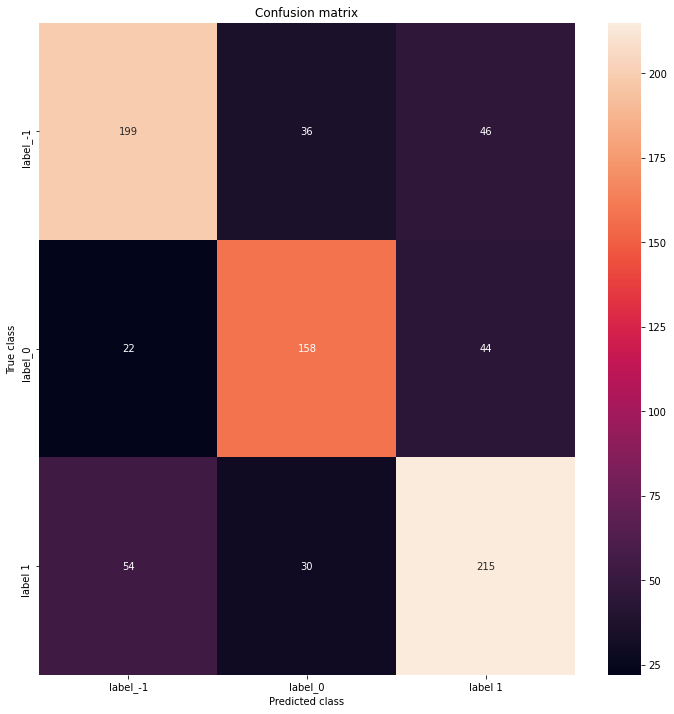

In [178]:
#creating and displaying confusion matrix
LABELS = ['label_-1', 'label_0', 'label 1']
conf_matrix = confusion_matrix(y_testPre, Pred_YPre)
plt.figure(figsize=(12, 12))
sb.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [179]:
#generating and printing a classification report
print(classification_report(y_testPre, Pred_YPre))

              precision    recall  f1-score   support

          -1       0.72      0.71      0.72       281
           0       0.71      0.71      0.71       224
           1       0.70      0.72      0.71       299

    accuracy                           0.71       804
   macro avg       0.71      0.71      0.71       804
weighted avg       0.71      0.71      0.71       804



In [180]:
print("Accuracy score: ", accuracy_score(y_testPre,Pred_YPre))

Accuracy score:  0.7114427860696517


In [181]:
wrong_classified_Pre = Pred_YPre != y_testPre

In [182]:
wrong_classified_Pre

0       True
1      False
2      False
3      False
4       True
       ...  
799     True
800    False
801    False
802    False
803    False
Name: label, Length: 804, dtype: bool

In [183]:
wrong_data_Pre = dfTest_Pre[wrong_classified_Pre == True]
wrong_labels_Pre = Pred_YPre[wrong_classified_Pre == True]

In [184]:
false_pronet_Pre = wrong_data_Pre[wrong_labels_Pre == 1]
false_pronet_Pre

,tweet,label
0,aspek historis calon ibu kota negara kutai kar...,0
7,pemindahan ibu kota kalimantan timur menimb...,0
8,beberapa aspek dikaji pemindahan ibu kota,0
18,proses pemindahan memakan biaya t sebagian dit...,-1
22,ngebayangin gmna proses pemindahan ibu kota ...,0
...,...,...
696,rak ternyata buku pak demokrasi perubahan ...,-1
759,geopolitik pemindahan ibu kota negara sangat ...,-1
770,pemindahan ibu kota merta berlangsung per...,0
791,pemindahan ibu kota kaltim turunkan aktivita...,-1


In [185]:
false_procon_Pre = wrong_data_Pre[wrong_labels_Pre == 0]
false_procon_Pre

,tweet,label
12,abis ngumumin pemindahan ibu kota negara biasa...,-1
32,sepertinya besar sengaja ditutupi dibalik ...,-1
44,luar pro kontra pemindahan ibu kota semua pu...,1
48,kondisi plus hutang negara t berbanggalah ...,-1
52,apbn membiayai pemindahan ibu kota kalimanta...,1
...,...,...
717,fabby tumiwa menilai pemindahan ibu kota baru ...,-1
739,pemindahan ibu kota hak presiden pic twitter ...,1
740,median merilis pendapat masyarakat terkait pem...,-1
771,fadli zon yakini pemindahan ibu kota tahun sulit,-1


In [186]:
false_netcon_Pre = wrong_data_Pre[wrong_labels_Pre == -1]
false_netcon_Pre

,tweet,label
4,negara dikelola sporadis,0
14,bapak tdk menolak tp bapak cuma menjelaskan ka...,0
19,terkait rencana pemindahan ibu kota kalimanta...,1
25,ngomong apa kau lek sok jago dikira mimpin neg...,0
30,pemindahan ibu kota pindah thn pemilihan presi...,0
...,...,...
762,moeldoko minta amien rais tendensius tanggapi...,1
763,sesuaikan kondisi pemindahan ibu kota karna u...,1
767,amien rais bahas rencana pemindahan ibu kota,0
796,pemindahan ibu kota amien rais caper,0


# dfPre Feature Selection

In [187]:
chPre = SelectKBest(chi2, k='all')
clfPre = svm.SVC()
# tfidf = TfidfVectorizer()

#constructing the pipeline
pipePre = Pipeline([
    # ('tfidf', tfidf),
    ('chi2', chPre),
    ('clf', clfPre)
])

para = {"chi2__k" : np.arange(50, 2800, 200)}

estimatorPre = GridSearchCV(pipePre,para)
estimatorPre.fit(Train_XPre_Tfidf.toarray(), y_trainPre)

GridSearchCV(cv=None, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('chi2',
                                        SelectKBest(k='all',
                                                    score_func=<function chi2 at 0x7f06b3b722f0>)),
                                       ('clf',
                                        SVC(C=1.0, break_ties=False,
                                            cache_size=200, class_weight=None,
                                            coef0=0.0,
                                            decision_function_shape='ovr',
                                            degree=3, gamma='scale',
                                            kernel='rbf', max_iter=-1,
                                            probability=False,
                                            random_state=None, shrinking=True,
                                            tol=0.001, verbose=False))],
                           

In [188]:
scorePre = estimatorPre.best_score_
bestPre = estimatorPre.best_params_

bestPre

{'chi2__k': 650}

In [189]:
scorePre

0.5943943262411348

In [190]:
print ("Select feature for training set via Chi2 ...")

chPre = SelectKBest(chi2, k=650)


x_trainPre_feature_selected = chPre.fit_transform(Train_XPre_Tfidf, y_trainPre)
print ("Select feature for testset via Chi2 ...")
x_testPre_chi_selected = chPre.transform(Test_XPre_Tfidf)
print ("Finished")

Select feature for training set via Chi2 ...
Select feature for testset via Chi2 ...
Finished


In [191]:
# Classifier - Algorithm - SVM
# fit the training dataset on the classifier
SVMPre = svm.SVC(kernel = 'linear')
SVMPre.fit(x_trainPre_feature_selected, y_trainPre)


# Use accuracy_score function to get the accuracy
print("SVM Training Accuracy Score -> ", SVMPre.score(x_trainPre_feature_selected, y_trainPre)*100)
print("SVM Testing Accuracy Score -> ", SVMPre.score(x_testPre_chi_selected, y_testPre)*100)

SVM Training Accuracy Score ->  76.7590618336887
SVM Testing Accuracy Score ->  65.79601990049751


In [192]:
chPre = SelectKBest(chi2, k=650)
clfPre = svm.SVC()
tfidfPre = TfidfVectorizer()

pipePre = Pipeline([
    ('tfidf', tfidfPre),
    ('chi2', chPre),
    ('clf', clfPre)
])

In [193]:
linear_grid = {'tfidf__max_features': [500, 1000, 5000, None],
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'clf__C': np.logspace(-1, 3, 5),
    'clf__kernel' : ['linear']}
    
poly_grid = {'tfidf__max_features': [500, 1000, 5000, None],
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'clf__C': np.logspace(-1, 3, 5),
    'clf__kernel' : ['poly'],
    'clf__degree' : [2, 3],
    'clf__gamma': np.logspace(-2, 2, 5)}

rbf_grid = {'tfidf__max_features': [500, 1000, 5000, None],
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'clf__C': np.logspace(-1, 3, 5),
    'clf__kernel' : ['rbf'],
    'clf__gamma': np.logspace(-2, 2, 5)}

In [194]:
scv_linear = RandomizedSearchCV(pipePre, param_distributions = linear_grid, n_iter = 10, cv = 5, verbose = 2, n_jobs = -1, return_train_score = True, random_state = 42)
scv_linear.fit(X_trainPre, y_trainPre);

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   13.2s finished


In [195]:
#using a randomized grid search to find the optimal value of the hyperparameters over a 5-fold cross-validation
scv_poly = RandomizedSearchCV(pipePre, param_distributions = poly_grid, n_iter = 10, cv = 5, verbose = 2, n_jobs = -1, return_train_score = True, random_state = 42)
scv_poly.fit(X_trainPre, y_trainPre);

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  2.7min finished


In [196]:
#using a randomized grid search to find the optimal value of the hyperparameters over a 5-fold cross-validation
scv_rbf = RandomizedSearchCV(pipePre, param_distributions = rbf_grid, n_iter = 10, cv = 5, verbose = 2, n_jobs = -1, return_train_score = True, random_state = 42)
scv_rbf.fit(X_trainPre, y_trainPre);

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   19.1s finished


In [197]:
#preview the best parameters as found by the gridsearch
scv_linear.best_params_

{'clf__C': 10.0,
 'clf__kernel': 'linear',
 'tfidf__max_features': None,
 'tfidf__ngram_range': (1, 1)}

In [198]:
scv_poly.best_params_

{'clf__C': 10.0,
 'clf__degree': 2,
 'clf__gamma': 10.0,
 'clf__kernel': 'poly',
 'tfidf__max_features': 5000,
 'tfidf__ngram_range': (1, 3)}

In [199]:
scv_rbf.best_params_

{'clf__C': 100.0,
 'clf__gamma': 0.1,
 'clf__kernel': 'rbf',
 'tfidf__max_features': 1000,
 'tfidf__ngram_range': (1, 2)}

In [200]:
scv_linear.best_estimator_

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='...
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('chi2',
                 SelectKBest(k=650,
                             score_func=<function chi2 at 0x7f06b3b722f0>)),
                ('clf',
                 SVC(C=10

In [201]:
scv_poly.best_estimator_

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=5000,
                                 min_df=1, ngram_range=(1, 3), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='...
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('chi2',
                 SelectKBest(k=650,
                             score_func=<function chi2 at 0x7f06b3b722f0>)),
                ('clf',
                 SVC(C=10

In [202]:
scv_rbf.best_estimator_

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=1000,
                                 min_df=1, ngram_range=(1, 2), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='...
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('chi2',
                 SelectKBest(k=650,
                             score_func=<function chi2 at 0x7f06b3b722f0>)),
                ('clf',
                 SVC(C=10

In [203]:
# Use accuracy_score function to get the accuracy
print("SVM Training Accuracy Score with chi square for data raw-> ", scv_linear.best_estimator_.score(X_trainPre, y_trainPre)*100)
print("SVM Testing Accuracy Score with chi square for data raw -> ", scv_linear.best_estimator_.score(X_testPre, y_testPre)*100)

SVM Training Accuracy Score with chi square for data raw->  85.18123667377398
SVM Testing Accuracy Score with chi square for data raw ->  65.17412935323384


In [204]:
# Use accuracy_score function to get the accuracy
print("SVM Training Accuracy Score with chi square for data raw-> ", scv_poly.best_estimator_.score(X_trainPre, y_trainPre)*100)
print("SVM Testing Accuracy Score with chi square for data raw -> ", scv_poly.best_estimator_.score(X_testPre, y_testPre)*100)

SVM Training Accuracy Score with chi square for data raw->  88.64605543710022
SVM Testing Accuracy Score with chi square for data raw ->  61.56716417910447


In [205]:
# Use accuracy_score function to get the accuracy
print("SVM Training Accuracy Score with chi square for data raw-> ", scv_rbf.best_estimator_.score(X_trainPre, y_trainPre)*100)
print("SVM Testing Accuracy Score with chi square for data raw -> ", scv_rbf.best_estimator_.score(X_testPre, y_testPre)*100)

SVM Training Accuracy Score with chi square for data raw->  93.7633262260128
SVM Testing Accuracy Score with chi square for data raw ->  61.69154228855721


In [206]:
#selecting the classifier with the hyperparameters yielding the highest average cross-validation score
best_clfchiPre = scv_linear.best_estimator_

In [207]:
#obtaining predictions and decision function scores
PredPre_Ychi = best_clfchiPre.predict(X_testPre)
ScorePre_Ychi = best_clfchiPre.decision_function(X_testPre)

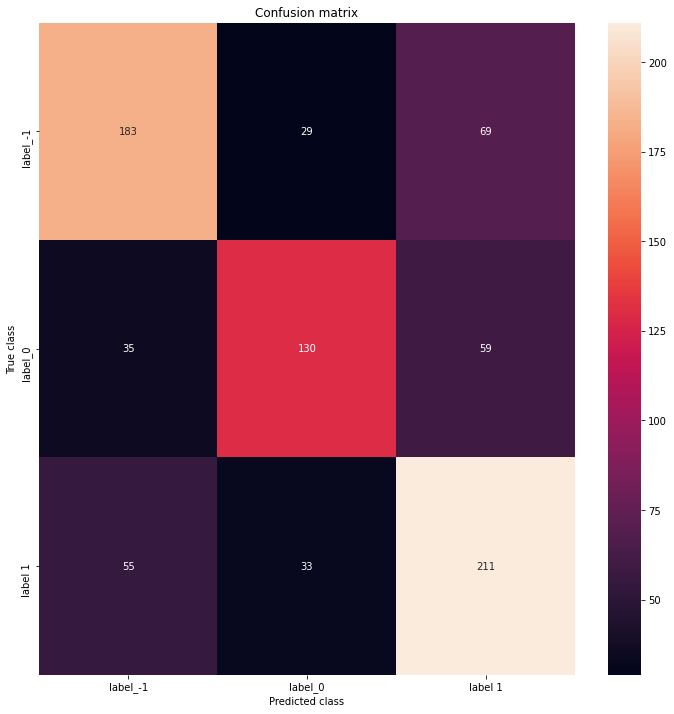

In [208]:
#creating and displaying confusion matrix
LABELS = ['label_-1', 'label_0', 'label 1']
conf_matrix = confusion_matrix(y_testPre,PredPre_Ychi)
plt.figure(figsize=(12, 12))
sb.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [209]:
#generating and printing a classification report
print(classification_report(y_testPre, PredPre_Ychi))

              precision    recall  f1-score   support

          -1       0.67      0.65      0.66       281
           0       0.68      0.58      0.62       224
           1       0.62      0.71      0.66       299

    accuracy                           0.65       804
   macro avg       0.66      0.65      0.65       804
weighted avg       0.65      0.65      0.65       804



In [210]:
print("Accuracy score with chi square data raw: ", accuracy_score(y_testPre,PredPre_Ychi))

Accuracy score with chi square data raw:  0.6517412935323383


In [211]:
wrong_classified_Pre_Chi = PredPre_Ychi != y_testPre

In [212]:
wrong_classified_Pre_Chi

0       True
1      False
2      False
3      False
4       True
       ...  
799     True
800    False
801    False
802    False
803    False
Name: label, Length: 804, dtype: bool

In [286]:
wrong_data_Pre_Chi = dfTest_Pre[wrong_classified_Pre_Chi == True]
wrong_labels_Pre_Chi = PredPre_Ychi[wrong_classified_Pre_Chi == True]

In [287]:
false_pronet_Pre_Chi = wrong_data_Pre_Chi[wrong_labels_Pre_Chi == 1]
false_pronet_Pre_Chi

,tweet,label
0,aspek historis calon ibu kota negara kutai kar...,0
4,negara dikelola sporadis,0
7,pemindahan ibu kota kalimantan timur menimb...,0
8,beberapa aspek dikaji pemindahan ibu kota,0
12,abis ngumumin pemindahan ibu kota negara biasa...,-1
...,...,...
740,median merilis pendapat masyarakat terkait pem...,-1
759,geopolitik pemindahan ibu kota negara sangat ...,-1
771,fadli zon yakini pemindahan ibu kota tahun sulit,-1
793,amien rais pemerintah menunggu kajian tiongkok...,-1


In [288]:
false_procon_Pre_Chi = wrong_data_Pre_Chi[wrong_labels_Pre_Chi == 0]
false_procon_Pre_Chi

,tweet,label
6,mudah an biaya pemindahan ibu kota menjadi aj...,-1
32,sepertinya besar sengaja ditutupi dibalik ...,-1
39,anies minta anggaran t mempercantik dki pinda...,1
47,pelaku usaha meminta pemindahan ibu kota ind...,1
48,kondisi plus hutang negara t berbanggalah ...,-1
...,...,...
706,pemindahan ibu kota ipb undang pakar transmigr...,1
715,sebut kondisi bangsa menjerit jalih pitoeng mi...,-1
739,pemindahan ibu kota hak presiden pic twitter ...,1
756,pemindahan ibu kota butuh dana dong pak dana ...,-1


In [289]:
false_netcon_Pre_Chi = wrong_data_Pre_Chi[wrong_labels_Pre_Chi == -1]
false_netcon_Pre_Chi

,tweet,label
14,bapak tdk menolak tp bapak cuma menjelaskan ka...,0
19,terkait rencana pemindahan ibu kota kalimanta...,1
30,pemindahan ibu kota pindah thn pemilihan presi...,0
33,terpecah belah cuma gara gara kepentingan poli...,0
51,terkait pemindahan ibu kota mardani pks pemeri...,0
...,...,...
767,amien rais bahas rencana pemindahan ibu kota,0
770,pemindahan ibu kota merta berlangsung per...,0
783,soal pemindahan ibu kota kaltim amien rais ke...,0
796,pemindahan ibu kota amien rais caper,0


# dfPreStem

In [218]:
# defining predictor and target features
X_trainPreStem = dfTrain_PreStem['tweet']
y_trainPreStem = dfTrain_PreStem['label']

X_testPreStem = dfTest_PreStem['tweet']
y_testPreStem = dfTest_PreStem['label']

In [219]:
#encoding the corpus using Term Frequency - Inverse Document Frequency Encoding
Tfidf_vect = TfidfVectorizer()

In [220]:
#fitting encoder on training data
Tfidf_vect.fit(X_trainPreStem)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [221]:
#Transforming the corpus for the training and testing data
Train_XPreStem_Tfidf = Tfidf_vect.transform(X_trainPreStem)
Test_XPreStem_Tfidf = Tfidf_vect.transform(X_testPreStem)

In [222]:
#preview vocabulary vector
print(Tfidf_vect.vocabulary_)

{'teliti': 3903, 'presiden': 3097, 'perlu': 2957, 'bentuk': 395, 'badan': 260, 'otorita': 2809, 'pindah': 3004, 'ibu': 1426, 'kota': 2008, 'news': 2629, 'berita': 415, 'kini': 1896, 'bangun': 302, 'pltn': 3033, 'kalbar': 1730, 'mantap': 2311, 'negara': 2620, 'prabowo': 3084, 'tuju': 4067, 'jadi': 1569, 'usul': 4176, 'rencana': 3271, 'jangka': 1590, 'panjang': 2863, 'gerindra': 1179, 'sejak': 3491, 'bukti': 554, 'jokowi': 1675, 'ada': 21, 'perata': 2939, 'lah': 2076, 'kan': 1752, 'sdh': 3466, 'mau': 2351, 'ringan': 3314, 'dg': 804, 'sudah': 3763, 'perintah': 2950, 'lebih': 2134, 'paham': 2830, 'biaya': 439, 'ri': 3302, 'ngurusin': 2673, 'oke': 2772, 'oce': 2761, 'nga': 2630, 'becus': 357, 'usa': 4165, 'bicara': 440, 'kalau': 1729, 'tudak': 4061, 'tau': 3874, 'masalah': 2333, 'rakyat': 3201, 'banyak': 310, 'keluh': 1824, 'sibuk': 3609, 'memang': 2384, 'benar': 385, 'jakarta': 1578, 'terlalu': 3932, 'berat': 403, 'sokong': 3693, 'beban': 354, 'kalo': 1737, 'mengahabiskan': 2401, 'dana': 7

In [223]:
#preview transformed training data
print(Train_XPreStem_Tfidf)

  (0, 3903)	0.4008139462282142
  (0, 3097)	0.207224514672524
  (0, 3004)	0.060150535627306066
  (0, 2957)	0.269169088181287
  (0, 2809)	0.4116471201775422
  (0, 2629)	0.3184431710819902
  (0, 2008)	0.059671742106590785
  (0, 1896)	0.3647985966861205
  (0, 1426)	0.05970354192239331
  (0, 415)	0.28379381168565243
  (0, 395)	0.3092838530159258
  (0, 260)	0.3647985966861205
  (1, 3033)	0.43936239558373924
  (1, 3004)	0.062197033081375794
  (1, 2629)	0.32927754075282883
  (1, 2620)	0.17681975371569164
  (1, 2311)	0.41445081100351827
  (1, 2008)	0.06170194960229273
  (1, 1896)	0.3772101137504415
  (1, 1730)	0.43936239558373924
  (1, 1426)	0.06173483134099754
  (1, 415)	0.2934493086324124
  (1, 302)	0.25015238204350604
  (2, 4176)	0.33713714861858324
  (2, 4067)	0.27784530263814383
  :	:
  (1873, 1426)	0.050381987042628265
  (1873, 745)	0.3382345903635643
  (1873, 671)	0.12790856013915664
  (1873, 629)	0.31262128863522903
  (1873, 578)	0.3933200964990272
  (1873, 127)	0.2361033170666132
  (18

In [224]:
# Classifier - Algorithm - SVM
# fit the training dataset on the classifier
SVM = svm.SVC(kernel = 'linear')
SVM.fit(Train_XPreStem_Tfidf, y_trainPreStem)

# Use accuracy_score function to get the accuracy
print("SVM Training Accuracy Score -> ", SVM.score(Train_XPreStem_Tfidf, y_trainPreStem)*100)
print("SVM Testing Accuracy Score -> ", SVM.score(Test_XPreStem_Tfidf, y_testPreStem)*100)

SVM Training Accuracy Score ->  92.75053304904051
SVM Testing Accuracy Score ->  69.40298507462687


In [225]:
#initializing tfidf vectorizer and an SVM classifier instance
tfidf = TfidfVectorizer()
clf = svm.SVC()

In [226]:
#constructing the pipeline
pipe = Pipeline([
    ('tfidf', tfidf),
    ('clf', clf)
])

In [227]:
linear_grid = {'tfidf__max_features': [500, 1000, 5000, None],
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'clf__C': np.logspace(-1, 3, 5),
    'clf__kernel' : ['linear']}
    
poly_grid = {'tfidf__max_features': [500, 1000, 5000, None],
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'clf__C': np.logspace(-1, 3, 5),
    'clf__kernel' : ['poly'],
    'clf__degree' : [2, 3],
    'clf__gamma': np.logspace(-2, 2, 5)}

rbf_grid = {'tfidf__max_features': [500, 1000, 5000, None],
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'clf__C': np.logspace(-1, 3, 5),
    'clf__kernel' : ['rbf'],
    'clf__gamma': np.logspace(-2, 2, 5)}

In [228]:
scv_linear = RandomizedSearchCV(pipe, param_distributions = linear_grid, n_iter = 10, cv = 5, verbose = 2, n_jobs = -1, return_train_score = True, random_state = 42)
scv_linear.fit(X_trainPreStem, y_trainPreStem);

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   23.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   31.2s finished


In [229]:
#using a randomized grid search to find the optimal value of the hyperparameters over a 5-fold cross-validation
scv_poly = RandomizedSearchCV(pipe, param_distributions = poly_grid, n_iter = 10, cv = 5, verbose = 2, n_jobs = -1, return_train_score = True, random_state = 42)
scv_poly.fit(X_trainPreStem, y_trainPreStem);

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   31.9s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   40.4s finished


In [230]:
#using a randomized grid search to find the optimal value of the hyperparameters over a 5-fold cross-validation
scv_rbf = RandomizedSearchCV(pipe, param_distributions = rbf_grid, n_iter = 10, cv = 5, verbose = 2, n_jobs = -1, return_train_score = True, random_state = 42)
scv_rbf.fit(X_trainPreStem, y_trainPreStem);

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   36.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   47.8s finished


In [231]:
#preview randomized gridsearch results
pd.DataFrame(scv_linear.cv_results_)[['params', 'mean_train_score', 'mean_test_score']]

,params,mean_train_score,mean_test_score
0,"{'tfidf__ngram_range': (1, 1), 'tfidf__max_fea...",0.637928,0.530926
1,"{'tfidf__ngram_range': (1, 3), 'tfidf__max_fea...",0.641660,0.529870
2,"{'tfidf__ngram_range': (1, 1), 'tfidf__max_fea...",0.978678,0.529348
3,"{'tfidf__ngram_range': (1, 1), 'tfidf__max_fea...",0.997068,0.599182
4,"{'tfidf__ngram_range': (1, 2), 'tfidf__max_fea...",0.793445,0.589051
5,"{'tfidf__ngram_range': (1, 1), 'tfidf__max_fea...",0.997068,0.599182
6,"{'tfidf__ngram_range': (1, 1), 'tfidf__max_fea...",0.994936,0.611967
7,"{'tfidf__ngram_range': (1, 1), 'tfidf__max_fea...",0.988939,0.520804
8,"{'tfidf__ngram_range': (1, 1), 'tfidf__max_fea...",0.815166,0.605566
9,"{'tfidf__ngram_range': (1, 1), 'tfidf__max_fea...",0.997068,0.599182


In [232]:
pd.DataFrame(scv_poly.cv_results_)[['params', 'mean_train_score', 'mean_test_score']]

,params,mean_train_score,mean_test_score
0,"{'tfidf__ngram_range': (1, 3), 'tfidf__max_fea...",0.989072,0.578386
1,"{'tfidf__ngram_range': (1, 3), 'tfidf__max_fea...",0.997068,0.603428
2,"{'tfidf__ngram_range': (1, 2), 'tfidf__max_fea...",0.989605,0.591170
3,"{'tfidf__ngram_range': (1, 3), 'tfidf__max_fea...",0.360874,0.360874
4,"{'tfidf__ngram_range': (1, 2), 'tfidf__max_fea...",0.360874,0.360874
5,"{'tfidf__ngram_range': (1, 3), 'tfidf__max_fea...",0.996668,0.601306
6,"{'tfidf__ngram_range': (1, 2), 'tfidf__max_fea...",0.360874,0.360874
7,"{'tfidf__ngram_range': (1, 2), 'tfidf__max_fea...",0.989605,0.591170
8,"{'tfidf__ngram_range': (1, 1), 'tfidf__max_fea...",0.360874,0.360874
9,"{'tfidf__ngram_range': (1, 2), 'tfidf__max_fea...",0.989605,0.591170


In [233]:
pd.DataFrame(scv_rbf.cv_results_)[['params', 'mean_train_score', 'mean_test_score']]

,params,mean_train_score,mean_test_score
0,"{'tfidf__ngram_range': (1, 3), 'tfidf__max_fea...",0.997068,0.625828
1,"{'tfidf__ngram_range': (1, 3), 'tfidf__max_fea...",0.989072,0.590645
2,"{'tfidf__ngram_range': (1, 3), 'tfidf__max_fea...",0.996135,0.625301
3,"{'tfidf__ngram_range': (1, 1), 'tfidf__max_fea...",0.360874,0.360874
4,"{'tfidf__ngram_range': (1, 3), 'tfidf__max_fea...",0.993337,0.375799
5,"{'tfidf__ngram_range': (1, 2), 'tfidf__max_fea...",0.997068,0.387525
6,"{'tfidf__ngram_range': (1, 2), 'tfidf__max_fea...",0.991604,0.575708
7,"{'tfidf__ngram_range': (1, 2), 'tfidf__max_fea...",0.989605,0.380065
8,"{'tfidf__ngram_range': (1, 3), 'tfidf__max_fea...",0.360874,0.360874
9,"{'tfidf__ngram_range': (1, 2), 'tfidf__max_fea...",0.996802,0.369933


In [234]:
#preview the best parameters as found by the gridsearch
scv_linear.best_params_

{'clf__C': 10.0,
 'clf__kernel': 'linear',
 'tfidf__max_features': None,
 'tfidf__ngram_range': (1, 1)}

In [235]:
#preview the best parameters as found by the gridsearch
scv_poly.best_params_

{'clf__C': 100.0,
 'clf__degree': 2,
 'clf__gamma': 100.0,
 'clf__kernel': 'poly',
 'tfidf__max_features': None,
 'tfidf__ngram_range': (1, 3)}

In [236]:
#preview the best parameters as found by the gridsearch
scv_rbf.best_params_

{'clf__C': 100.0,
 'clf__gamma': 0.1,
 'clf__kernel': 'rbf',
 'tfidf__max_features': None,
 'tfidf__ngram_range': (1, 3)}

In [237]:
scv_linear.best_estimator_

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 SVC(C=10.0, break_ties=False, cache_size=200,
                     class_weight=None, coef0=0.0,
                     decision_fun

In [238]:
scv_poly.best_estimator_

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 3), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 SVC(C=100.0, break_ties=False, cache_size=200,
                     class_weight=None, coef0=0.0,
                     decision_fu

In [239]:
scv_rbf.best_estimator_

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 3), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 SVC(C=100.0, break_ties=False, cache_size=200,
                     class_weight=None, coef0=0.0,
                     decision_fu

In [240]:
# Use accuracy_score function to get the accuracy
print("SVM Training Accuracy Score -> ", scv_linear.best_estimator_.score(X_trainPreStem, y_trainPreStem)*100)
print("SVM Testing Accuracy Score -> ", scv_linear.best_estimator_.score(X_testPreStem, y_testPreStem)*100)

SVM Training Accuracy Score ->  99.46695095948827
SVM Testing Accuracy Score ->  67.91044776119402


In [241]:
# Use accuracy_score function to get the accuracy
print("SVM Training Accuracy Score -> ", scv_poly.best_estimator_.score(X_trainPreStem, y_trainPreStem)*100)
print("SVM Testing Accuracy Score -> ", scv_poly.best_estimator_.score(X_testPreStem, y_testPreStem)*100)

SVM Training Accuracy Score ->  99.68017057569296
SVM Testing Accuracy Score ->  70.52238805970148


In [242]:
# Use accuracy_score function to get the accuracy
print("SVM Training Accuracy Score -> ", scv_rbf.best_estimator_.score(X_trainPreStem, y_trainPreStem)*100)
print("SVM Testing Accuracy Score -> ", scv_rbf.best_estimator_.score(X_testPreStem, y_testPreStem)*100)

SVM Training Accuracy Score ->  99.68017057569296
SVM Testing Accuracy Score ->  71.64179104477611


In [243]:
#selecting the classifier with the hyperparameters yielding the highest average cross-validation score
best_clf = scv_rbf.best_estimator_

In [244]:
#obtaining predictions and decision function scores
Pred_YPreStem = best_clf.predict(X_testPreStem)
Score_YPreStem = best_clf.decision_function(X_testPreStem)

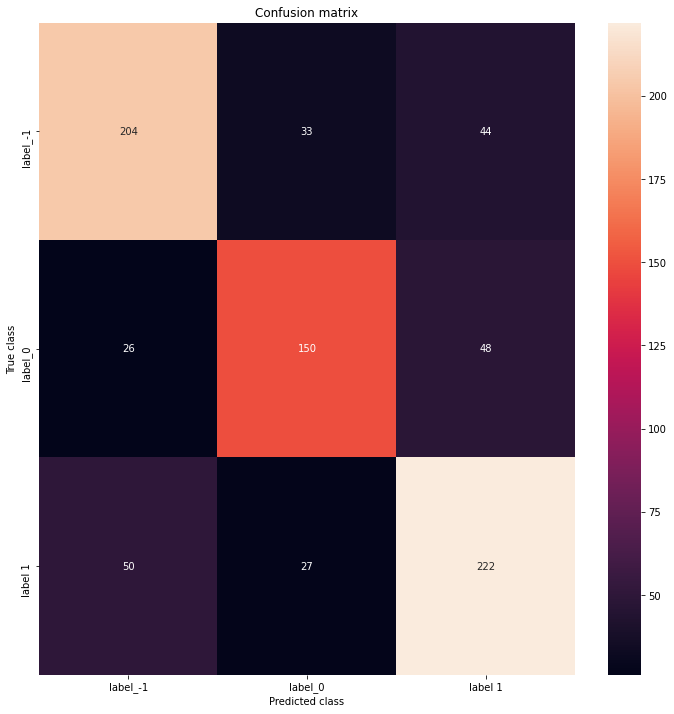

In [245]:
#creating and displaying confusion matrix
LABELS = ['label_-1', 'label_0', 'label 1']
conf_matrix = confusion_matrix(y_testPreStem, Pred_YPreStem)
plt.figure(figsize=(12, 12))
sb.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [246]:
#generating and printing a classification report
print(classification_report(y_testPreStem, Pred_YPreStem))

              precision    recall  f1-score   support

          -1       0.73      0.73      0.73       281
           0       0.71      0.67      0.69       224
           1       0.71      0.74      0.72       299

    accuracy                           0.72       804
   macro avg       0.72      0.71      0.71       804
weighted avg       0.72      0.72      0.72       804



In [247]:
print("Accuracy score: ", accuracy_score(y_testPreStem,Pred_YPreStem))

Accuracy score:  0.7164179104477612


In [248]:
wrong_classified_PreStem = Pred_YPreStem != y_testPreStem

In [249]:
wrong_classified_PreStem

0       True
1      False
2      False
3      False
4       True
       ...  
799    False
800    False
801     True
802    False
803    False
Name: label, Length: 804, dtype: bool

In [250]:
wrong_data_PreStem = dfTest_PreStem[wrong_classified_PreStem == True]
wrong_labels_PreStem = Pred_YPreStem[wrong_classified_PreStem == True]

In [251]:
false_pronet_PreStem = wrong_data_PreStem[wrong_labels_PreStem == 1]
false_pronet_PreStem

,tweet,label
0,aspek historis calon ibu kota negara kuta kart...,0
7,pindah ibu kota kalimantan timur timbul aru...,0
18,proses pindah makan biaya t bagi tanggung wila...,-1
22,ngebayangin gmna proses pindah ibu kota yg ...,0
27,serius nnya skema ppp alias kpbu proses pinda...,0
...,...,...
770,pindah ibu kota merta langsung perlu tuju...,0
783,soal pindah ibu kota kaltim amien rais keluar...,0
791,pindah ibu kota kaltim turun aktivitas ekono...,-1
795,survei median mayoritas tolak ibu kota pindah ...,-1


In [252]:
false_procon_PreStem = wrong_data_PreStem[wrong_labels_PreStem == 0]
false_procon_PreStem

,tweet,label
12,abis ngumumin pindah ibu kota negara biasa jaw...,-1
32,seperti besar sengaja tutup balik rencana ...,-1
44,luar pro kontra pindah ibu kota semua punya ...,1
52,apbn biaya pindah ibu kota kalimantan timur ...,1
53,masyarakat gunung mas minta hormat putus pinda...,1
65,jokowi putus pindah ibu kota bakal tel dana h...,1
75,pindah ibu kota nafi masalah lingkung hadap ...,1
80,presiden joko widodo sampai butuh biaya pindah...,1
87,maksud umum presiden tadi jelas surat dpr ...,1
99,simpul data kaji tri badan buka presiden ...,-1


In [253]:
len(false_procon_PreStem)

60

In [254]:
false_netcon_PreStem = wrong_data_PreStem[wrong_labels_PreStem == -1]
false_netcon_PreStem

,tweet,label
4,negara kelola sporadis,0
14,bapak tdk tolak tp bapak cuma jelas kakurangan...,0
19,kait rencana pindah ibu kota kalimantan banya...,1
33,pecah belah cuma gara gara penting politik pro...,0
34,pikir klo pindah ibu kota bukan pikir ide pak ...,0
...,...,...
762,moeldoko minta amien rais tendensius tanggap ...,1
763,sesuai kondisi pindah ibu kota karna utk kelo...,1
767,amien rais bahas rencana pindah ibu kota,0
796,pindah ibu kota amien rais caper,0


# dfPreStem Feature Selection

In [255]:
chPreStem = SelectKBest(chi2)
clfPreStem = svm.SVC()
# tfidf = TfidfVectorizer()

#constructing the pipeline
pipePreStem = Pipeline([
    # ('tfidf', tfidf),
    ('chi2', chPreStem),
    ('clf', clfPreStem)
])

para = {"chi2__k" : np.arange(50, 2800, 200)}

estimatorPreStem = GridSearchCV(pipePreStem,para)
estimatorPreStem.fit(Train_XPreStem_Tfidf.toarray(), y_trainPreStem)

GridSearchCV(cv=None, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('chi2',
                                        SelectKBest(k=10,
                                                    score_func=<function chi2 at 0x7f06b3b722f0>)),
                                       ('clf',
                                        SVC(C=1.0, break_ties=False,
                                            cache_size=200, class_weight=None,
                                            coef0=0.0,
                                            decision_function_shape='ovr',
                                            degree=3, gamma='scale',
                                            kernel='rbf', max_iter=-1,
                                            probability=False,
                                            random_state=None, shrinking=True,
                                            tol=0.001, verbose=False))],
                              

In [256]:
scorePreStem = estimatorPreStem.best_score_
bestPreStem = estimatorPreStem.best_params_

bestPreStem

{'chi2__k': 2650}

In [257]:
scorePreStem

0.6060992907801418

In [258]:
print ("Select feature for training set via Chi2 ...")

chPreStem = SelectKBest(chi2, k=2650)


x_trainPreStem_feature_selected=chPreStem.fit_transform(Train_XPreStem_Tfidf, y_trainPreStem)
print ("Select feature for testset via Chi2 ...")
x_testPreStem_chi_selected = chPreStem.transform(Test_XPreStem_Tfidf)
print ("Finished")

Select feature for training set via Chi2 ...
Select feature for testset via Chi2 ...
Finished


In [259]:
# Classifier - Algorithm - SVM
# fit the training dataset on the classifier
SVMPreStem = svm.SVC(kernel = 'linear')
SVMPreStem.fit(x_trainPreStem_feature_selected, y_trainPreStem)


# Use accuracy_score function to get the accuracy
print("SVM Training Accuracy Score -> ", SVMPreStem.score(x_trainPreStem_feature_selected, y_trainPreStem)*100)
print("SVM Testing Accuracy Score -> ", SVMPreStem.score(x_testPreStem_chi_selected, y_testPreStem)*100)

SVM Training Accuracy Score ->  89.17910447761194
SVM Testing Accuracy Score ->  69.02985074626866


In [260]:
chPreStem = SelectKBest(chi2, k=2650)
clfPreStem = svm.SVC()
tfidfPreStem = TfidfVectorizer()

pipePreStem = Pipeline([
    ('tfidf', tfidfPreStem),
    ('chi2', chPreStem),
    ('clf', clfPreStem)
])

In [261]:
linear_grid = {'tfidf__max_features': [500, 1000, 5000, None],
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'clf__C': np.logspace(-1, 3, 5),
    'clf__kernel' : ['linear']}
    
poly_grid = {'tfidf__max_features': [500, 1000, 5000, None],
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'clf__C': np.logspace(-1, 3, 5),
    'clf__kernel' : ['poly'],
    'clf__degree' : [2, 3],
    'clf__gamma': np.logspace(-2, 2, 5)}

rbf_grid = {'tfidf__max_features': [500, 1000, 5000, None],
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'clf__C': np.logspace(-1, 3, 5),
    'clf__kernel' : ['rbf'],
    'clf__gamma': np.logspace(-2, 2, 5)}

In [262]:
scv_linear = RandomizedSearchCV(pipePreStem, param_distributions = linear_grid, n_iter = 10, cv = 5, verbose = 2, n_jobs = -1, return_train_score = True, random_state = 42)
scv_linear.fit(X_trainPreStem, y_trainPreStem);

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   11.8s finished


In [263]:
#using a randomized grid search to find the optimal value of the hyperparameters over a 5-fold cross-validation
scv_poly = RandomizedSearchCV(pipePreStem, param_distributions = poly_grid, n_iter = 10, cv = 5, verbose = 2, n_jobs = -1, return_train_score = True, random_state = 42)
scv_poly.fit(X_trainPreStem, y_trainPreStem);

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   20.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  2.2min finished


In [264]:
#using a randomized grid search to find the optimal value of the hyperparameters over a 5-fold cross-validation
scv_rbf = RandomizedSearchCV(pipePreStem, param_distributions = rbf_grid, n_iter = 10, cv = 5, verbose = 2, n_jobs = -1, return_train_score = True, random_state = 42)
scv_rbf.fit(X_trainPreStem, y_trainPreStem);

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   18.0s finished


In [265]:
#preview the best parameters as found by the gridsearch
scv_linear.best_params_

{'clf__C': 10.0,
 'clf__kernel': 'linear',
 'tfidf__max_features': None,
 'tfidf__ngram_range': (1, 1)}

In [266]:
scv_poly.best_params_

{'clf__C': 10.0,
 'clf__degree': 2,
 'clf__gamma': 10.0,
 'clf__kernel': 'poly',
 'tfidf__max_features': 5000,
 'tfidf__ngram_range': (1, 3)}

In [267]:
scv_rbf.best_params_

{'clf__C': 10.0,
 'clf__gamma': 1.0,
 'clf__kernel': 'rbf',
 'tfidf__max_features': 5000,
 'tfidf__ngram_range': (1, 3)}

In [268]:
scv_linear.best_estimator_

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='...
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('chi2',
                 SelectKBest(k=2650,
                             score_func=<function chi2 at 0x7f06b3b722f0>)),
                ('clf',
                 SVC(C=1

In [269]:
scv_poly.best_estimator_

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=5000,
                                 min_df=1, ngram_range=(1, 3), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='...
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('chi2',
                 SelectKBest(k=2650,
                             score_func=<function chi2 at 0x7f06b3b722f0>)),
                ('clf',
                 SVC(C=1

In [270]:
scv_rbf.best_estimator_

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=5000,
                                 min_df=1, ngram_range=(1, 3), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='...
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('chi2',
                 SelectKBest(k=2650,
                             score_func=<function chi2 at 0x7f06b3b722f0>)),
                ('clf',
                 SVC(C=1

In [271]:
# Use accuracy_score function to get the accuracy
print("SVM Training Accuracy Score with chi square for data raw-> ", scv_linear.best_estimator_.score(X_trainPreStem, y_trainPreStem)*100)
print("SVM Testing Accuracy Score with chi square for data raw -> ", scv_linear.best_estimator_.score(X_testPreStem, y_testPreStem)*100)

SVM Training Accuracy Score with chi square for data raw->  98.72068230277186
SVM Testing Accuracy Score with chi square for data raw ->  67.03980099502488


In [272]:
# Use accuracy_score function to get the accuracy
print("SVM Training Accuracy Score with chi square for data raw-> ", scv_poly.best_estimator_.score(X_trainPreStem, y_trainPreStem)*100)
print("SVM Testing Accuracy Score with chi square for data raw -> ", scv_poly.best_estimator_.score(X_testPreStem, y_testPreStem)*100)

SVM Training Accuracy Score with chi square for data raw->  99.20042643923242
SVM Testing Accuracy Score with chi square for data raw ->  59.82587064676616


In [273]:
# Use accuracy_score function to get the accuracy
print("SVM Training Accuracy Score with chi square for data raw-> ", scv_rbf.best_estimator_.score(X_trainPreStem, y_trainPreStem)*100)
print("SVM Testing Accuracy Score with chi square for data raw -> ", scv_rbf.best_estimator_.score(X_testPreStem, y_testPreStem)*100)

SVM Training Accuracy Score with chi square for data raw->  98.72068230277186
SVM Testing Accuracy Score with chi square for data raw ->  66.4179104477612


In [274]:
#selecting the classifier with the hyperparameters yielding the highest average cross-validation score
best_clfchiPreStem = scv_linear.best_estimator_

In [275]:
#obtaining predictions and decision function scores
PredPreStem_Ychi = best_clfchiPreStem.predict(X_testPreStem)
ScorePreStem_Ychi = best_clfchiPreStem.decision_function(X_testPreStem)

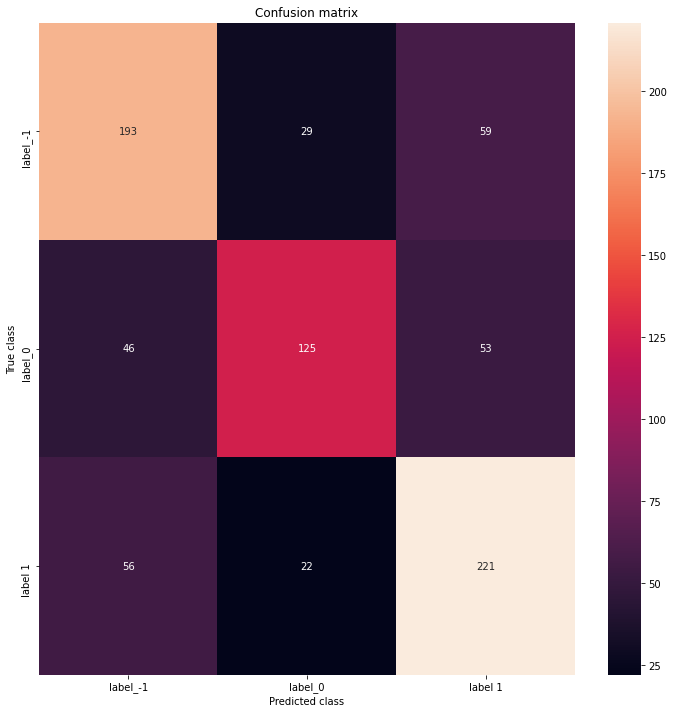

In [276]:
#creating and displaying confusion matrix
LABELS = ['label_-1', 'label_0', 'label 1']
conf_matrix = confusion_matrix(y_testPreStem, PredPreStem_Ychi)
plt.figure(figsize=(12, 12))
sb.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [277]:
#generating and printing a classification report
print(classification_report(y_testPreStem, PredPreStem_Ychi))

              precision    recall  f1-score   support

          -1       0.65      0.69      0.67       281
           0       0.71      0.56      0.63       224
           1       0.66      0.74      0.70       299

    accuracy                           0.67       804
   macro avg       0.68      0.66      0.66       804
weighted avg       0.67      0.67      0.67       804



In [278]:
print("Accuracy score with chi square data raw: ", accuracy_score(y_testPreStem,PredPreStem_Ychi))

Accuracy score with chi square data raw:  0.6703980099502488


In [279]:
wrong_classified_PreStem_Chi = PredPreStem_Ychi != y_testPreStem

In [280]:
wrong_classified_PreStem_Chi

0       True
1      False
2      False
3      False
4       True
       ...  
799     True
800    False
801    False
802    False
803    False
Name: label, Length: 804, dtype: bool

In [281]:
wrong_data_PreStem_Chi = dfTest_PreStem[wrong_classified_PreStem_Chi == True]
wrong_labels_PreStem_Chi = PredPreStem_Ychi[wrong_classified_PreStem_Chi == True]

In [282]:
false_pronet_PreStem_Chi = wrong_data_PreStem_Chi[wrong_labels_PreStem_Chi == 1]
false_pronet_PreStem_Chi

,tweet,label
0,aspek historis calon ibu kota negara kuta kart...,0
6,mudah an biaya pindah ibu kota jadi ajang meg...,-1
8,beberapa aspek kaji pindah ibu kota,0
13,kakak dapid td lg meeting pindah ibu kota kata,0
17,pindah ibu kota trending twitter lihat koment...,0
...,...,...
770,pindah ibu kota merta langsung perlu tuju...,0
772,taufid nilai pindah ibu kota justru potensi ha...,-1
774,yg bikin hutang negara naik yg suka ambil put...,-1
793,amien rais perintah tunggu kaji tiongkok soal ...,-1


In [283]:
false_procon_PreStem_Chi = wrong_data_PreStem_Chi[wrong_labels_PreStem_Chi == 0]
false_procon_PreStem_Chi

,tweet,label
12,abis ngumumin pindah ibu kota negara biasa jaw...,-1
32,seperti besar sengaja tutup balik rencana ...,-1
38,semua terlalu sibuk urusin pindah ibu kota ayo...,-1
47,laku usaha minta pindah ibu kota indonesia ...,1
48,kondisi plus hutang negara t bangga pinda...,-1
53,masyarakat gunung mas minta hormat putus pinda...,1
55,mohon kaji kabid mitigasi gempa tsunami bmkg...,-1
87,maksud umum presiden tadi jelas surat dpr ...,1
113,suara bogor shared alas pindah ibu kota beban...,1
122,aspek hukum pindah ibu kota jelas umum,-1


In [284]:
len(false_procon_PreStem_Chi)

51

In [285]:
false_netcon_PreStem_Chi = wrong_data_PreStem_Chi[wrong_labels_PreStem_Chi == -1]
false_netcon_PreStem_Chi

,tweet,label
4,negara kelola sporadis,0
7,pindah ibu kota kalimantan timur timbul aru...,0
14,bapak tdk tolak tp bapak cuma jelas kakurangan...,0
19,kait rencana pindah ibu kota kalimantan banya...,1
33,pecah belah cuma gara gara penting politik pro...,0
...,...,...
767,amien rais bahas rencana pindah ibu kota,0
783,soal pindah ibu kota kaltim amien rais keluar...,0
796,pindah ibu kota amien rais caper,0
797,pindah ibu kota ri perspektif tahan,0
